### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
sns.set()
from functools import reduce
from numpy import mean
from numpy import std
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.cluster import KMeans, AgglomerativeClustering
from xgboost import XGBClassifier
from sklearn.svm import SVC  
from sklearn.linear_model import Lasso, ElasticNet
from operator import itemgetter
from itertools import product
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score, f1_score, roc_curve, auc, silhouette_score
from mrmr import mrmr_classif
from yellowbrick.cluster import SilhouetteVisualizer

%matplotlib inline 

### Read diabetes file and convert to dataframe 

In [2]:
# Define filepath
filepath = 'D:\FYP\Merged_abundance_species_D.xlsx'

# Load Excel file using Pandas with `sheet_name=None`
df_first = pd.read_excel(filepath, sheet_name='First')
df_second = pd.read_excel(filepath, sheet_name='Second')
df_third = pd.read_excel(filepath, sheet_name='Third')
df_fourth = pd.read_excel(filepath, sheet_name='Fourth')
df_fifth = pd.read_excel(filepath, sheet_name='Fifth')
df_sixth = pd.read_excel(filepath, sheet_name='Sixth')
df_seventh = pd.read_excel(filepath, sheet_name='Seventh')

# Preview
df_first.head(5)

,body_site,SRR1778451d,SRR1778454d,SRR1778456d,SRR341663d,SRR341666d,SRR341685d,SRR341700d,SRR341725d,SRR413556d,SRR413615d
0,Bacteroides_caccae,22.20384,2.41857,0.53348,0.00293,0.06965,1.87127,0.40095,0.00364,0.24959,3.62311
1,Phocaeicola_dorei,13.38680,0.00000,1.78776,18.02465,0.15120,3.37103,2.16329,16.66221,0.00000,0.87098
2,Ruthenibacterium_lactatiformans,8.77166,0.05257,0.02502,0.08182,0.01096,0.02320,0.00000,0.06363,0.00000,0.24460
3,Ruminococcus_torques,6.97158,0.20878,0.01473,0.52422,0.76816,0.32991,0.21744,0.31802,0.03404,0.90843
4,Bacteroides_stercoris,5.34026,12.59911,0.88870,13.13054,0.59907,8.14250,0.01088,2.63578,0.00000,7.67505


In [3]:
# Get the shape of all sheets
print("First :", df_first.shape)
print("Second :", df_second.shape)
print("Third :", df_third.shape)
print("Fourth :", df_fourth.shape)
print("Fifth :", df_fifth.shape)
print("Sixth :", df_sixth.shape)
print("Seventh :", df_seventh.shape)

First : (1290, 11)
Second : (1559, 11)
Third : (1415, 11)
Fourth : (1339, 11)
Fifth : (1283, 11)
Sixth : (1527, 11)
Seventh : (1160, 11)


In [4]:
# concatenate all the sheets 
# df_T2D_ori --> ORIGINAL DATASET WITH ALL ROWS AND COLUMNS
dfs = [df_first,df_second,df_third,df_fourth,df_fifth,df_sixth,df_seventh]
df_T2D_ori = pd.concat(dfs)
print("df_T2D :", df_T2D_ori.shape)
df_T2D_ori.head()

df_T2D : (9573, 71)


,body_site,SRR1778451d,SRR1778454d,SRR1778456d,SRR341663d,SRR341666d,SRR341685d,SRR341700d,SRR341725d,SRR413556d,...,SRR18845028d,SRR18845030d,SRR18845046d,SRR18845047d,SRR18845120d,SRR18845127d,SRR2912789d,SRR413581d,SRR413589d,SRR413596d
0,Bacteroides_caccae,22.20384,2.41857,0.53348,0.00293,0.06965,1.87127,0.40095,0.00364,0.24959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Phocaeicola_dorei,13.38680,0.00000,1.78776,18.02465,0.15120,3.37103,2.16329,16.66221,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ruthenibacterium_lactatiformans,8.77166,0.05257,0.02502,0.08182,0.01096,0.02320,0.00000,0.06363,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Ruminococcus_torques,6.97158,0.20878,0.01473,0.52422,0.76816,0.32991,0.21744,0.31802,0.03404,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Bacteroides_stercoris,5.34026,12.59911,0.88870,13.13054,0.59907,8.14250,0.01088,2.63578,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# convert all NaN to 0s
# df_convert --> dataframe of converted NaN to 0 
df_convert = df_T2D_ori.replace(np.nan, 0)
# get number of NaN values
print("Sum of NaN : ", df_convert.isnull().sum().sum())
df_convert.head()

Sum of NaN :  0


,body_site,SRR1778451d,SRR1778454d,SRR1778456d,SRR341663d,SRR341666d,SRR341685d,SRR341700d,SRR341725d,SRR413556d,...,SRR18845028d,SRR18845030d,SRR18845046d,SRR18845047d,SRR18845120d,SRR18845127d,SRR2912789d,SRR413581d,SRR413589d,SRR413596d
0,Bacteroides_caccae,22.20384,2.41857,0.53348,0.00293,0.06965,1.87127,0.40095,0.00364,0.24959,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Phocaeicola_dorei,13.38680,0.00000,1.78776,18.02465,0.15120,3.37103,2.16329,16.66221,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Ruthenibacterium_lactatiformans,8.77166,0.05257,0.02502,0.08182,0.01096,0.02320,0.00000,0.06363,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ruminococcus_torques,6.97158,0.20878,0.01473,0.52422,0.76816,0.32991,0.21744,0.31802,0.03404,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bacteroides_stercoris,5.34026,12.59911,0.88870,13.13054,0.59907,8.14250,0.01088,2.63578,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# drop dupliate rows and keep the first row
# df_dropD --> dataframe with duplicates of row dropped
df_dropD = df_convert.drop_duplicates()
# convert column name to 1 for classification
df_dropD.columns.values[1::] = ["1"]
df_dropD.shape

(9573, 71)

In [7]:
# set the species as index
# df_tranposed --> tranposed dataframe
df_tranposed = df_dropD.set_index('body_site')
#transposing 
df_tranposed = df_tranposed.transpose()
df_tranposed.head()

body_site,Bacteroides_caccae,Phocaeicola_dorei,Ruthenibacterium_lactatiformans,Ruminococcus_torques,Bacteroides_stercoris,Parabacteroides_merdae,Escherichia_coli,Phascolarctobacterium_faecium,Clostridium_symbiosum,Faecalimonas_umbilicata,...,Acidaminococcaceae_unclassified_SGB5785|t__SGB5785,Eggerthellaceae_unclassified_SGB14332|t__SGB14332,GGB6010_SGB8637|t__SGB8637,Clostridia_bacterium|t__SGB6350,Faecalitalea_cylindroides|t__SGB6790,Faecalibacillus_faecis|t__SGB6750,GGB4599_SGB6362|t__SGB6362,Erysipelotrichaceae_bacterium|t__SGB4027,Hungatella_hathewayi|t__SGB4739,Akkermansia_muciniphila|t__SGB9228
1,22.20384,13.38680,8.77166,6.97158,5.34026,4.03416,3.09670,3.03010,2.94102,2.46709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.41857,0.00000,0.05257,0.20878,12.59911,0.08135,0.07551,3.68943,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.53348,1.78776,0.02502,0.01473,0.88870,0.03893,0.16322,0.06395,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00293,18.02465,0.08182,0.52422,13.13054,0.00000,0.75182,1.67737,0.09199,0.04891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.06965,0.15120,0.01096,0.76816,0.59907,0.29396,0.00768,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# https://datascience.stackexchange.com/questions/47023/pandas-merge-column-duplicate-and-sum-value
# merge duplicate column and sum values --> why i can do that?
# I concatenate all the sheets so the rows will keep on adding 
# blanks are filled with 0, so it wouldnt chnage the value
# df_T2D --> final dataset
df_T2D = df_tranposed.groupby(by=df_tranposed.columns, axis=1).sum()
df_T2D.shape

(70, 2665)

In [9]:
df_T2D.head()

body_site,Absicoccus_porci,Absicoccus_porci|t__SGB6818,Acidaminococcaceae_bacterium,Acidaminococcaceae_bacterium|t__SGB5789,Acidaminococcaceae_bacterium|t__SGB5790,Acidaminococcaceae_unclassified_SGB5785,Acidaminococcaceae_unclassified_SGB5785|t__SGB5785,Acidaminococcus_fermentans,Acidaminococcus_fermentans|t__SGB5743,Acidaminococcus_fermentans|t__SGB5744,...,Veillonellaceae_bacterium,Veillonellaceae_bacterium|t__SGB6925,Victivallis_vadensis,Victivallis_vadensis|t__SGB9202,Weissella_cibaria,Weissella_cibaria|t__SGB7114,Weissella_confusa,Weissella_confusa|t__SGB7115,bacterium_OL_1,bacterium_OL_1|t__SGB14389_group
1,0.0,0.0,0.00032,0.0,0.00032,0.0,0.0,0.00000,0.0,0.00000,...,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00000
1,0.0,0.0,0.00151,0.0,0.00151,0.0,0.0,0.00000,0.0,0.00000,...,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00000
1,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00000,...,0.0,0.0,0.00297,0.00297,0.0,0.0,0.0,0.0,0.00000,0.00000
1,0.0,0.0,0.00155,0.0,0.00155,0.0,0.0,0.00000,0.0,0.00000,...,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00000
1,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,1.12297,0.0,1.12297,...,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,1.97906,1.97906


In [22]:
df_T2D.to_csv('df_T2D.csv')

### Read healthy file and convert to dataframe 

In [10]:
# Define filepath
filepath = 'D:\FYP\Merged_abundance_species_H.xlsx'

# Load Excel file using Pandas with `sheet_name=None`
df_first = pd.read_excel(filepath, sheet_name='First')
df_second = pd.read_excel(filepath, sheet_name='Second')
df_third = pd.read_excel(filepath, sheet_name='Third')
df_fourth = pd.read_excel(filepath, sheet_name='Fourth')
df_fifth = pd.read_excel(filepath, sheet_name='Fifth')
df_sixth = pd.read_excel(filepath, sheet_name='Sixth')
df_seventh = pd.read_excel(filepath, sheet_name='Seventh')
df_eighth = pd.read_excel(filepath, sheet_name='Eighth')

# Preview
df_first.head(5)


,body_site,SRR14291150d,SRR14291151d,SRR14291152d,SRR14291153d,SRR14291154d,SRR14291155d,SRR14291157d,SRR14291158d,SRR14291159d,SRR14291160d
0,Bacteroides_cellulosilyticus,18.60051,17.20937,7.06138,18.16592,19.99929,11.39672,11.28170,0.65627,0.00000,0.50790
1,Bacteroides_faecis,10.55020,3.47546,6.60903,9.40725,3.12679,1.27695,0.06691,0.00000,0.00000,0.68922
2,Phocaeicola_vulgatus,9.06499,2.10031,3.18053,1.23001,0.20254,0.05381,0.01709,0.00000,0.00000,4.93430
3,Eubacterium_rectale,5.22744,7.01090,3.99328,2.32306,2.87885,7.14584,1.52566,2.33559,0.86579,0.52591
4,Phocaeicola_dorei,5.11111,6.48962,7.57169,16.61204,18.48076,27.14424,19.29572,15.56528,15.47851,0.56460


In [11]:
print("First :", df_first.shape)
print("Second :", df_second.shape)
print("Third :", df_third.shape)
print("Fourth :", df_fourth.shape)
print("Fifth :", df_fifth.shape)
print("Sixth :", df_sixth.shape)
print("Seventh :", df_seventh.shape)
print("Eighth :", df_eighth.shape)

First : (457, 11)
Second : (1223, 11)
Third : (786, 11)
Fourth : (956, 11)
Fifth : (1725, 11)
Sixth : (1814, 11)
Seventh : (949, 11)
Eighth : (1184, 13)


In [12]:
# concatenate all the sheets 
# df_h_ori --> ORIGINAL DATASET WITH ALL ROWS AND COLUMNS
dfs = [df_first,df_second,df_third,df_fourth,df_fifth,df_sixth,df_seventh, df_eighth]
df_h_ori = pd.concat(dfs)
print("df_h_ori :", df_h_ori.shape)
df_h_ori.head()

df_h_ori : (9094, 83)


,body_site,SRR14291150d,SRR14291151d,SRR14291152d,SRR14291153d,SRR14291154d,SRR14291155d,SRR14291157d,SRR14291158d,SRR14291159d,...,ERR527171d,ERR527186d,ERR527191d,ERR527206d,ERR527215d,ERR528300d,ERR528307d,ERR528335d,ERR528739d,ERR532378d
0,Bacteroides_cellulosilyticus,18.60051,17.20937,7.06138,18.16592,19.99929,11.39672,11.28170,0.65627,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bacteroides_faecis,10.55020,3.47546,6.60903,9.40725,3.12679,1.27695,0.06691,0.00000,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Phocaeicola_vulgatus,9.06499,2.10031,3.18053,1.23001,0.20254,0.05381,0.01709,0.00000,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Eubacterium_rectale,5.22744,7.01090,3.99328,2.32306,2.87885,7.14584,1.52566,2.33559,0.86579,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Phocaeicola_dorei,5.11111,6.48962,7.57169,16.61204,18.48076,27.14424,19.29572,15.56528,15.47851,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# convert all NaN to 0s
# df_convert_h --> dataframe of converted NaN to 0 
df_convert_h = df_h_ori.replace(np.nan, 0)
# get number of NaN values
print("Sum of NaN : ", df_convert_h.isnull().sum().sum())
df_convert_h.head()

Sum of NaN :  0


,body_site,SRR14291150d,SRR14291151d,SRR14291152d,SRR14291153d,SRR14291154d,SRR14291155d,SRR14291157d,SRR14291158d,SRR14291159d,...,ERR527171d,ERR527186d,ERR527191d,ERR527206d,ERR527215d,ERR528300d,ERR528307d,ERR528335d,ERR528739d,ERR532378d
0,Bacteroides_cellulosilyticus,18.60051,17.20937,7.06138,18.16592,19.99929,11.39672,11.28170,0.65627,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bacteroides_faecis,10.55020,3.47546,6.60903,9.40725,3.12679,1.27695,0.06691,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Phocaeicola_vulgatus,9.06499,2.10031,3.18053,1.23001,0.20254,0.05381,0.01709,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Eubacterium_rectale,5.22744,7.01090,3.99328,2.32306,2.87885,7.14584,1.52566,2.33559,0.86579,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Phocaeicola_dorei,5.11111,6.48962,7.57169,16.61204,18.48076,27.14424,19.29572,15.56528,15.47851,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# drop dupliate rows and keep the first row
# df_dropD_h --> dataframe with duplicates of row dropped
df_dropD_h = df_convert_h.drop_duplicates()
# convert column name to 1 for classification
df_dropD_h.columns.values[1::] = ["0"]
df_dropD_h.shape

(9027, 83)

In [15]:
# set the species as index
# df_tranposed_h --> tranposed dataframe
df_tranposed_h = df_dropD_h.set_index('body_site')
#transposing 
df_tranposed_h = df_tranposed_h.transpose()
df_tranposed_h.head()

body_site,Bacteroides_cellulosilyticus,Bacteroides_faecis,Phocaeicola_vulgatus,Eubacterium_rectale,Phocaeicola_dorei,Bacteroides_ovatus,Ruminococcus_bromii,Coprococcus_eutactus,Faecalibacterium_prausnitzii,Alistipes_putredinis,...,Nanosynsacchari_sp_TM7_ANC_38_39_G1_1|t__SGB19882,sedentarius|t__SGB17151,delbrueckii,SGB42794,sinensis,_Megasphaera_elsdenii,delbrueckii|t__SGB7020,SGB42794|t__SGB42794,sinensis|t__SGB8030,_Megasphaera_elsdenii|t__SGB5862
0,18.60051,10.55020,9.06499,5.22744,5.11111,5.07750,3.99757,2.52089,2.19702,2.11874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,17.20937,3.47546,2.10031,7.01090,6.48962,5.16640,4.76655,2.91244,2.86088,1.98171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,7.06138,6.60903,3.18053,3.99328,7.57169,2.27636,3.37551,1.09130,1.30621,3.96419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,18.16592,9.40725,1.23001,2.32306,16.61204,2.65159,3.15151,0.67878,2.34709,3.27259,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,19.99929,3.12679,0.20254,2.87885,18.48076,3.67753,3.40766,1.51262,1.83727,2.57382,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# df_h --> final dataset
df_H = df_tranposed_h.groupby(by=df_tranposed_h.columns, axis=1).sum()
df_H.shape

(82, 4152)

In [21]:
df_H.to_csv('df_H.csv')

### Combining healthy and diabetes dataste

In [17]:
# append
# df_combined --> dataframe that combines both healthy and diabetes dataset
dfs = [df_T2D, df_H]
df_combined = pd.concat(dfs)
print("df_combined :", df_combined.shape)
df_combined.head()

df_combined : (152, 5833)


body_site,Absicoccus_porci,Absicoccus_porci|t__SGB6818,Acidaminococcaceae_bacterium,Acidaminococcaceae_bacterium|t__SGB5789,Acidaminococcaceae_bacterium|t__SGB5790,Acidaminococcaceae_unclassified_SGB5785,Acidaminococcaceae_unclassified_SGB5785|t__SGB5785,Acidaminococcus_fermentans,Acidaminococcus_fermentans|t__SGB5743,Acidaminococcus_fermentans|t__SGB5744,...,vadensis,vadensis|t__SGB9202,vanvlietii,vanvlietii|t__SGB63325,veronii,veronii|t__SGB9947_group,virosa,virosa|t__SGB1784,xylanisolvens,xylanisolvens|t__SGB1867
1,0.0,0.0,0.00032,0.0,0.00032,0.0,0.0,0.00000,0.0,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.00151,0.0,0.00151,0.0,0.0,0.00000,0.0,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.00155,0.0,0.00155,0.0,0.0,0.00000,0.0,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,1.12297,0.0,1.12297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# convert all NaN to 0s
df_combined = df_combined.replace(np.nan, 0)
print("Sum of NaN : ", df_combined.isnull().sum().sum())
df_combined.head()


Sum of NaN :  0


body_site,Absicoccus_porci,Absicoccus_porci|t__SGB6818,Acidaminococcaceae_bacterium,Acidaminococcaceae_bacterium|t__SGB5789,Acidaminococcaceae_bacterium|t__SGB5790,Acidaminococcaceae_unclassified_SGB5785,Acidaminococcaceae_unclassified_SGB5785|t__SGB5785,Acidaminococcus_fermentans,Acidaminococcus_fermentans|t__SGB5743,Acidaminococcus_fermentans|t__SGB5744,...,vadensis,vadensis|t__SGB9202,vanvlietii,vanvlietii|t__SGB63325,veronii,veronii|t__SGB9947_group,virosa,virosa|t__SGB1784,xylanisolvens,xylanisolvens|t__SGB1867
1,0.0,0.0,0.00032,0.0,0.00032,0.0,0.0,0.00000,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00151,0.0,0.00151,0.0,0.0,0.00000,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00155,0.0,0.00155,0.0,0.0,0.00000,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,1.12297,0.0,1.12297,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# drop any duplication
df_combined = df_combined.drop_duplicates()
df_combined.shape

(151, 5833)

In [20]:
df_combined.to_csv('df_combined.csv')

### Split data to training and testing set 

In [2]:
# Define filepath
filepath = 'D:\FYP\df_combined.csv'
df_combined = pd.read_csv(filepath)

# Preview
df_combined.head()

,Unnamed: 0,Absicoccus_porci,Absicoccus_porci|t__SGB6818,Acidaminococcaceae_bacterium,Acidaminococcaceae_bacterium|t__SGB5789,Acidaminococcaceae_bacterium|t__SGB5790,Acidaminococcaceae_unclassified_SGB5785,Acidaminococcaceae_unclassified_SGB5785|t__SGB5785,Acidaminococcus_fermentans,Acidaminococcus_fermentans|t__SGB5743,...,vadensis,vadensis|t__SGB9202,vanvlietii,vanvlietii|t__SGB63325,veronii,veronii|t__SGB9947_group,virosa,virosa|t__SGB1784,xylanisolvens,xylanisolvens|t__SGB1867
0,1,0.0,0.0,0.00032,0.0,0.00032,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.00151,0.0,0.00151,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.00155,0.0,0.00155,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,1.12297,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# rename first column to label
df_combined.rename(columns={"Unnamed: 0": "Label"}, inplace=True)
df_combined.head()

,Label,Absicoccus_porci,Absicoccus_porci|t__SGB6818,Acidaminococcaceae_bacterium,Acidaminococcaceae_bacterium|t__SGB5789,Acidaminococcaceae_bacterium|t__SGB5790,Acidaminococcaceae_unclassified_SGB5785,Acidaminococcaceae_unclassified_SGB5785|t__SGB5785,Acidaminococcus_fermentans,Acidaminococcus_fermentans|t__SGB5743,...,vadensis,vadensis|t__SGB9202,vanvlietii,vanvlietii|t__SGB63325,veronii,veronii|t__SGB9947_group,virosa,virosa|t__SGB1784,xylanisolvens,xylanisolvens|t__SGB1867
0,1,0.0,0.0,0.00032,0.0,0.00032,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.00151,0.0,0.00151,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.00155,0.0,0.00155,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,1.12297,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# shuffle data, frac=1 --> return the whole dataframe and reset index
# random_state to reproduce data
df = df_combined.sample(frac=1, random_state=42)
df.head()

,Label,Absicoccus_porci,Absicoccus_porci|t__SGB6818,Acidaminococcaceae_bacterium,Acidaminococcaceae_bacterium|t__SGB5789,Acidaminococcaceae_bacterium|t__SGB5790,Acidaminococcaceae_unclassified_SGB5785,Acidaminococcaceae_unclassified_SGB5785|t__SGB5785,Acidaminococcus_fermentans,Acidaminococcus_fermentans|t__SGB5743,...,vadensis,vadensis|t__SGB9202,vanvlietii,vanvlietii|t__SGB63325,veronii,veronii|t__SGB9947_group,virosa,virosa|t__SGB1784,xylanisolvens,xylanisolvens|t__SGB1867
76,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000
18,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000
82,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000
81,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000
143,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.51001,0.51001


In [5]:
# check the shape of X and y
X = df.drop(['Label'],axis=1)
y = df['Label']
print("X : ", X.shape)
print("y : ", y.shape)

X :  (151, 5833)
y :  (151,)


In [6]:
# training --> 90, testing --> 10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print("X_train : ", X_train.shape)
print("y_train : ", y_train.shape)
print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

X_train :  (135, 5833)
y_train :  (135,)
X_test :  (16, 5833)
y_test :  (16,)


### SMOTE Analysis

0    74
1    61
Name: Label, dtype: int64


Text(0.5, 1.02, 'Total Number of Data per Label')

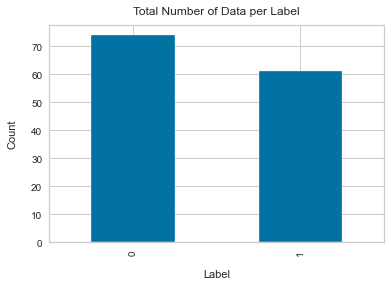

In [7]:
# bar graph to show the number of data per labels
print(y_train.value_counts())
y_train.value_counts().plot(kind='bar')
plt.xlabel("Label", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Total Number of Data per Label", y=1.02)

In [8]:
#https://www.kaggle.com/code/qianchao/smote-with-imbalance-data
# X_train_b --> balanced
print("Before Oversampling, counts of label '1' : {}".format(sum(y_train==1)))
print("Before Oversampling, counts of label '0' : {} \n".format(sum(y_train==0)))

# smote analysis
sm = SMOTE(random_state=42)
X_train_b, y_train_b = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_b.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_b.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_b==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_b==0)))


Before Oversampling, counts of label '1' : 61
Before Oversampling, counts of label '0' : 74 

After OverSampling, the shape of train_X: (148, 5833)
After OverSampling, the shape of train_y: (148,) 

After OverSampling, counts of label '1': 74
After OverSampling, counts of label '0': 74


In [9]:
a = np.array(y_train_b)
a = pd.DataFrame(a)
print(a.value_counts())

0    74
1    74
dtype: int64


0    74
1    74
dtype: int64


Text(0.5, 1.02, 'Total Number of Data per Label')

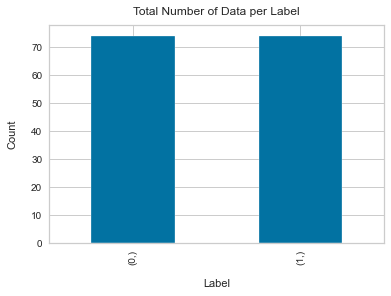

In [10]:
# bar graph to show the number of data per labels
print(a.value_counts())
a.value_counts().plot(kind='bar')
plt.xlabel("Label", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Total Number of Data per Label", y=1.02)

### Classification Models Function

In [12]:
#https://www.kaggle.com/code/mnpathak1/model-comparison-with-roc-curves-and-more

# without cross validation
def trainModels(X_train, y_train, X_test, y_test):
        acc = []
        precision = []
        recall = []
        specificity = []
        f1 = []
        fpr_list = []
        tpr_list = []
        roc_auc = []
        classifiers = ['SVM', 'AdaBoost', 'Random Forest', 'XGBoost']
        models=[SVC(kernel='rbf', verbose=True, random_state=42, probability=True), 
                AdaBoostClassifier(random_state=42),
                RandomForestClassifier(n_estimators=100,random_state=42, verbose=True),
                XGBClassifier(random_state=42)] 
        for i in models :
            model = i
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test) 
            y_pred_prob = model.predict_proba(X_test)[:,1]
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
            acc.append(accuracy_score(y_pred, y_test))
            precision.append(precision_score(y_pred, y_test))
            recall.append(recall_score(y_test, y_pred, pos_label=1))
            specificity.append(recall_score(y_test,y_pred, pos_label=0))
            f1.append(f1_score(y_test, y_pred))
            fpr_list.append(fpr)
            tpr_list.append(tpr)
            roc_auc.append(auc(fpr,tpr))

        # plot the auc-roc curve
        plt.figure(figsize=[5,5])
        plt.plot([0,1],[0,1], 'k--')
        plt.plot(fpr_list[0],tpr_list[0], label = str(classifiers[0]) + '(area =%0.03f)'% roc_auc[0])
        plt.plot(fpr_list[1],tpr_list[1], label = str(classifiers[1]) + '(area =%0.03f)'% roc_auc[1])
        plt.plot(fpr_list[2],tpr_list[2], label = str(classifiers[2]) + '(area =%0.03f)'% roc_auc[2])
        plt.plot(fpr_list[3],tpr_list[3], label = str(classifiers[3]) + '(area =%0.03f)'% roc_auc[3])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curves from the investigated models')
        plt.legend(loc='best')
        plt.show()
            
        models_df = pd.DataFrame(list(zip(acc,precision, recall,specificity, f1)), index=classifiers)
        models_df.columns=['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1']

        # plot bar graph
        models_df_t = models_df.transpose()
        models_df_t.plot(figsize=(6,6),kind='bar')
        plt.legend(bbox_to_anchor=(1.0, 1.0), title='Labels')
        plt.title('Performance of Classification Models')
        plt.ylabel('Score')
        plt.xlabel('Evaluation Metrics')
        return models_df

# with cross validation
def trainModelsCV(X_train, y_train):
    kfold = KFold(n_splits=10)
    acc = []
    precision = []
    recall = []
    specificity_list = []
    f1 = []
    classifiers = ['SVM', 'AdaBoost', 'Random Forest', 'XGBoost']
    models=[SVC(kernel='rbf', verbose=True, random_state=42), 
            AdaBoostClassifier(random_state=42),
            RandomForestClassifier(n_estimators=100,random_state=42),
            XGBClassifier(random_state=42)] 
    
    for i in models :
        model = i
        specificity = make_scorer(recall_score, pos_label=0)
        acc.append(cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy').mean())
        precision.append(cross_val_score(model, X_train, y_train, cv=kfold, scoring='precision').mean())
        recall.append(cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall').mean())
        specificity_list.append(cross_val_score(model, X_train, y_train, cv=kfold, scoring=specificity).mean())
        f1.append(cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1').mean())
    models_df = pd.DataFrame(list(zip(acc,precision, recall, specificity_list, f1)), index=classifiers)
    models_df.columns=['Accuracy Mean', 'Precision Mean', 'Recall Mean', 'Specificity Mean','F1 Mean']

    # plot bar graph
    models_df_t = models_df.transpose()
    models_df_t.plot(figsize=(6,6),kind='bar')
    plt.legend(bbox_to_anchor=(1.0, 1.0), title='Labels')
    plt.title('Performance of Classification Models')
    plt.ylabel('Score')
    plt.xlabel('Evaluation Metrics')
    
    return models_df

### Pairwise Function

https://towardsdatascience.com/how-to-use-pairwise-correlation-for-robust-feature-selection-20a60ef7d10

In [16]:
def correlation_matrix(df: pd.DataFrame):
    matrix = df.corr()
    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    fig, ax = plt.subplots(figsize=(16,12))
    _ = sns.heatmap(matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, ax=ax)

In [17]:
# function to drop highly related columns
def drop_cols(df, threshold):
    matrix = df.corr().abs()
    mask = np.triu(np.ones_like(matrix,dtype=bool))
    reduced_matrix = matrix.mask(mask)
    cols = [c for c in reduced_matrix.columns if any(reduced_matrix[c] > threshold)]
    return cols

### Top Features Function

In [18]:
def topFeatures(df, X_train, X_test, i):
    # get the top 20 features
    # sort the df values
    feat_selection_list = ['mRMR', 'Select K Best', 'Lasso-Based Feature Selection', 'ElasticNet Feature Selection', 'Random Forest Feature Importance']
    df_descending = df.sort_values(by='Score', ascending=False)
    df_feat = df_descending[:20].copy()
    print('DF shape :', df_feat.shape)
    print(df_feat)

    # top 20 features in bar graph
    df_feat.plot(kind='barh', 
                  x='Features',
                  y='Score',
                  title='Top 20 Feature Scores Using '+ str(feat_selection_list[i]),
                  figsize=(10,10))

    # make the features as index
    df_feat = df_feat.set_index(df_feat.columns[0])

    # get top features list name 
    feat_names = df_feat.index
    col_list = list(feat_names)

    # drop the columns that are not in the list 
    X_train_drop = X_train.drop(columns=[col for col in X_train if col not in col_list])
    X_test_drop = X_test.drop(columns=[col for col in X_test if col not in col_list])
    print('X train shape :', X_train_drop.shape)
    print('X test shape :', X_test_drop.shape)

    return df_feat, X_train_drop, X_test_drop

### Classification without Feature Selection

[LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


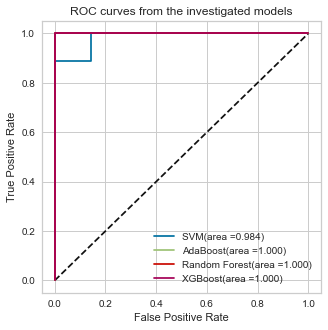

,Accuracy,Precision,Recall,Specificity,F1
SVM,0.9375,0.888889,0.888889,1.000000,0.941176
AdaBoost,0.9375,1.000000,1.000000,0.857143,0.947368
Random Forest,1.0000,1.000000,1.000000,1.000000,1.000000
XGBoost,0.9375,1.000000,1.000000,0.857143,0.947368


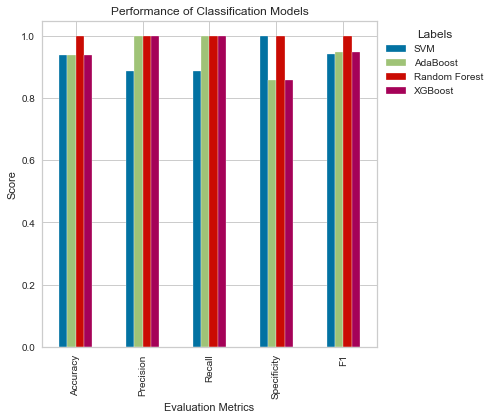

In [16]:
trainModels(X_train_b,y_train_b,X_test,y_test)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

,Accuracy Mean,Precision Mean,Recall Mean,Specificity Mean,F1 Mean
SVM,0.932381,0.908822,0.974603,0.876389,0.937021
AdaBoost,0.979524,0.973214,0.988889,0.975000,0.979759
Random Forest,0.959524,0.935607,1.000000,0.900000,0.964808
XGBoost,0.972381,0.962500,0.990909,0.962500,0.974286


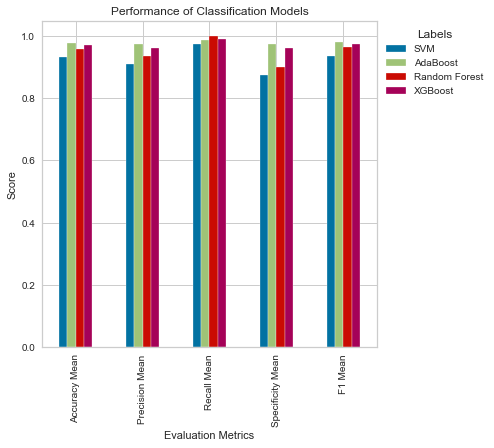

In [17]:
#6mins
trainModelsCV(X_train_b,y_train_b)

### Feature Selection
mRMR, sKb, Lasso-based feature selection, Elastic-net feature selection, Random Forest feature selection 


#### Select K Best

In [19]:
# use select k best to select the features with the best chi-squared
chi2_features = SelectKBest(chi2, k=500) 
feat = chi2_features.fit(X_train_b,y_train_b)

In [20]:
# get the scores and features
dfScores = pd.DataFrame(feat.scores_)
dfColumns = pd.DataFrame(X.columns)
dfFeatureScores_skb = pd.concat([dfColumns,dfScores],axis=1)
dfFeatureScores_skb.columns = ['Features','Score']
print('dfFeatureScores. :' ,dfFeatureScores_skb.shape)
dfFeatureScores_skb.head()

dfFeatureScores. : (5833, 2)


,Features,Score
0,Absicoccus_porci,0.082680
1,Absicoccus_porci|t__SGB6818,0.082680
2,Acidaminococcaceae_bacterium,2.011374
3,Acidaminococcaceae_bacterium|t__SGB5789,0.000350
4,Acidaminococcaceae_bacterium|t__SGB5790,2.011034


DF shape : (20, 2)
                                    Features       Score
5792                            unclassified  733.620720
5820             unclassified|g__Phocaeicola  656.037490
5038                   _Phocaeicola_vulgatus  345.777880
5039        _Phocaeicola_vulgatus|t__SGB1814  345.777880
1101            Faecalibacterium_prausnitzii  269.127670
5822              uniformis|t__SGB1836_group  227.248760
5821                               uniformis  227.248760
2346     Prevotella_copri_clade_A|t__SGB1626  171.877002
2345                Prevotella_copri_clade_A  171.877002
5682                   putredinis|t__SGB2318  166.506520
5681                              putredinis  166.506520
270   Bacteroides_uniformis|t__SGB1836_group  157.845759
269                    Bacteroides_uniformis  157.845759
3755                    _Cutibacterium_acnes  150.592160
3756        _Cutibacterium_acnes|t__SGB16955  150.592160
5775              stercoris|t__SGB1830_group  150.280960
5774        

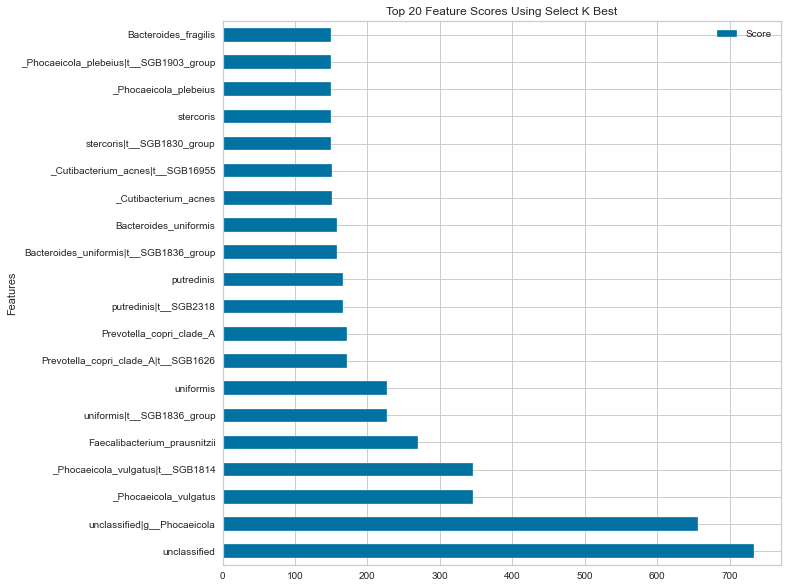

In [21]:
df_skb_20, X_train_skb, X_test_skb = topFeatures(dfFeatureScores_skb, X_train_b, X_test, 1)

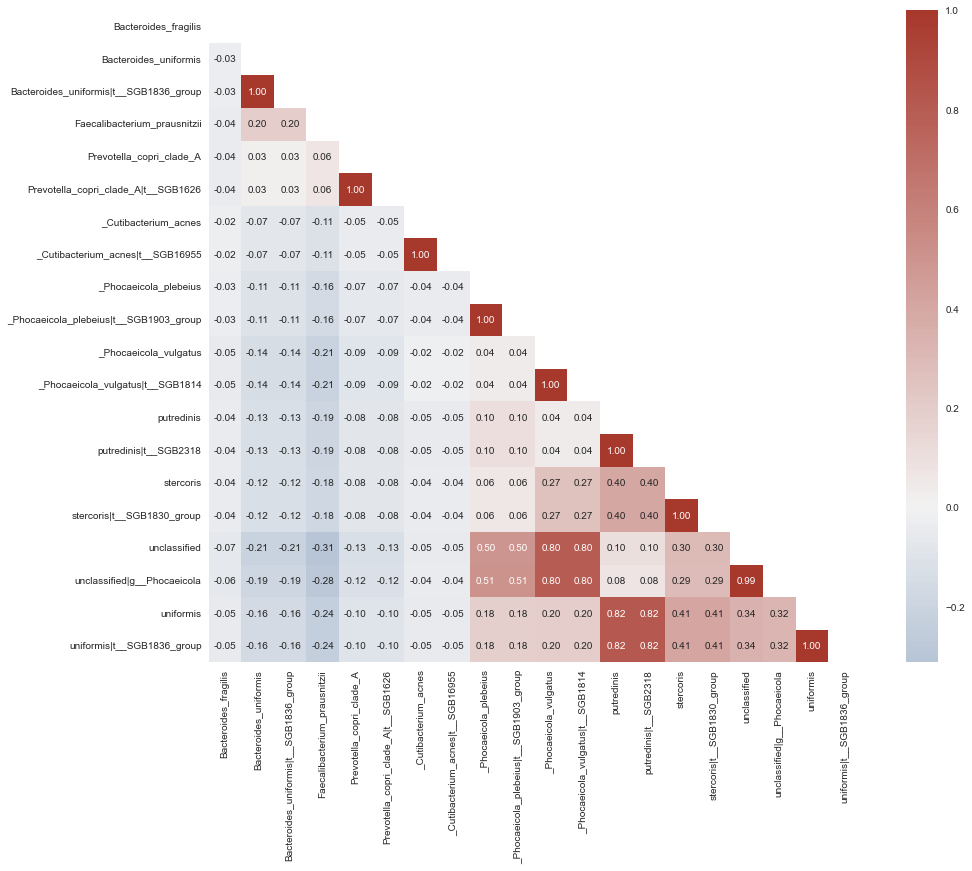

In [22]:
# pairwise correlation 
correlation_matrix(X_train_skb)

In [23]:
# drop highly related cols
cols = drop_cols(X_train_skb,.9)
cols

['Bacteroides_uniformis',
 'Prevotella_copri_clade_A',
 '_Cutibacterium_acnes',
 '_Phocaeicola_plebeius',
 '_Phocaeicola_vulgatus',
 'putredinis',
 'stercoris',
 'unclassified',
 'uniformis']

In [24]:
# drop the columns that are highly related
X_train_skb = X_train_skb.drop(cols, axis=1)
X_test_skb = X_test_skb.drop(cols, axis=1)
print('X train shape :', X_train_skb.shape)
print('X test shape :', X_test_skb.shape)

X train shape : (148, 11)
X test shape : (16, 11)


[LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


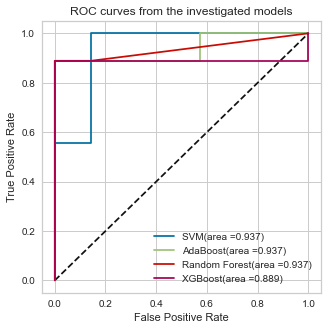

,Accuracy,Precision,Recall,Specificity,F1
SVM,0.7500,0.555556,0.555556,1.0,0.714286
AdaBoost,0.9375,0.888889,0.888889,1.0,0.941176
Random Forest,0.8750,0.777778,0.777778,1.0,0.875000
XGBoost,0.9375,0.888889,0.888889,1.0,0.941176


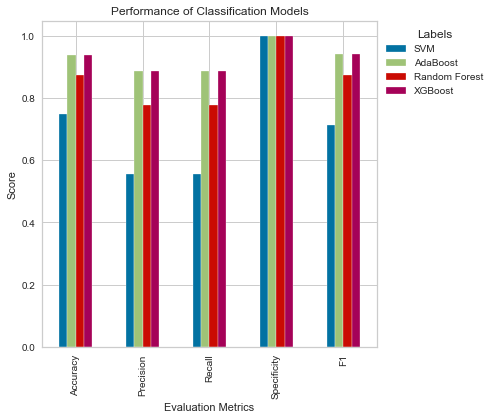

In [24]:
trainModels(X_train_skb,y_train_b, X_test_skb, y_test)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

,Accuracy Mean,Precision Mean,Recall Mean,Specificity Mean,F1 Mean
SVM,0.878571,0.929167,0.846664,0.908333,0.880253
AdaBoost,0.899048,0.915714,0.911860,0.883333,0.911094
Random Forest,0.926190,0.921699,0.954040,0.883333,0.934757
XGBoost,0.906190,0.915714,0.919553,0.883333,0.915094


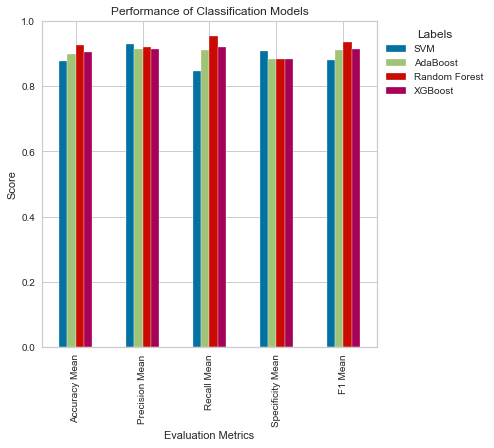

In [25]:
trainModelsCV(X_train_skb,y_train_b)

#### Random Forest Feature Selection

https://www.blog.trainindata.com/feature-selection-machine-learning-with-python/
https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection

In [25]:
# https://www.kaggle.com/code/prashant111/random-forest-classifier-feature-importance

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_b, y_train_b)

RandomForestClassifier(random_state=42)

In [26]:
# get the scores and features
dfScores = pd.DataFrame(rf.feature_importances_)
dfColumns = pd.DataFrame(X_train_b.columns)
dfFeatureScores_RF = pd.concat([dfColumns,dfScores],axis=1)
dfFeatureScores_RF.columns = ['Features','Score']
print('dfFeatureScores. :' ,dfFeatureScores_RF.shape)
dfFeatureScores_RF.head()

dfFeatureScores. : (5833, 2)


,Features,Score
0,Absicoccus_porci,0.0
1,Absicoccus_porci|t__SGB6818,0.0
2,Acidaminococcaceae_bacterium,0.0
3,Acidaminococcaceae_bacterium|t__SGB5789,0.0
4,Acidaminococcaceae_bacterium|t__SGB5790,0.0


DF shape : (20, 2)
                                            Features     Score
1143              Flavonifractor_plautii|t__SGB15132  0.028079
791                               Clostridium_fessum  0.022901
317                                   Blautia_faecis  0.022718
349                Blautia_wexlerae|t__SGB4837_group  0.021821
1102  Faecalibacterium_prausnitzii|t__SGB15316_group  0.021469
1050                    Escherichia_coli|t__SGB10068  0.020862
265                     Bacteroides_thetaiotaomicron  0.020238
2596       Streptococcus_salivarius|t__SGB8007_group  0.019457
243                               Bacteroides_ovatus  0.018944
272             Bacteroides_xylanisolvens|t__SGB1867  0.018229
1142                          Flavonifractor_plautii  0.017148
2319                 Phocaeicola_vulgatus|t__SGB1814  0.014896
1016          Enterocloster_bolteae|t__SGB4758_group  0.014153
1159      Fusicatenibacter_saccharivorans|t__SGB4874  0.013097
1017                         Enteroc

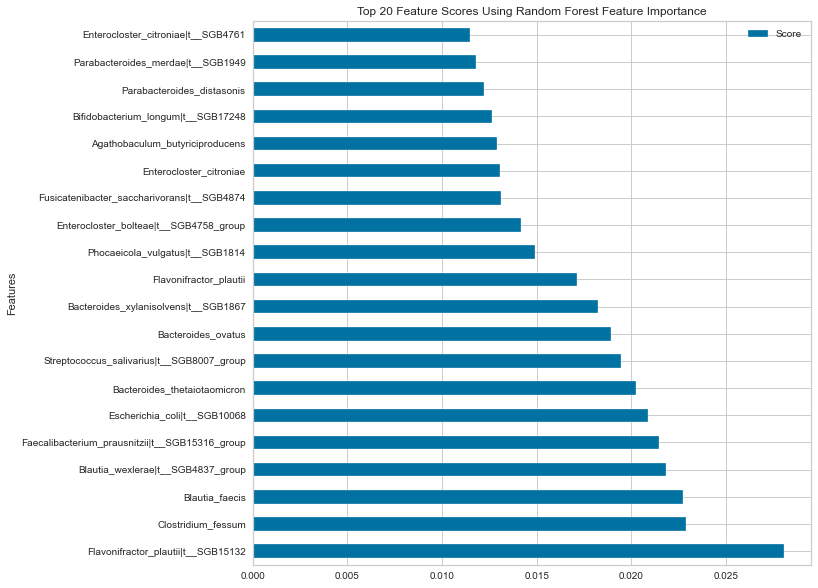

In [27]:
df_RF_20, X_train_rf, X_test_rf = topFeatures(dfFeatureScores_RF, X_train_b, X_test, 4)

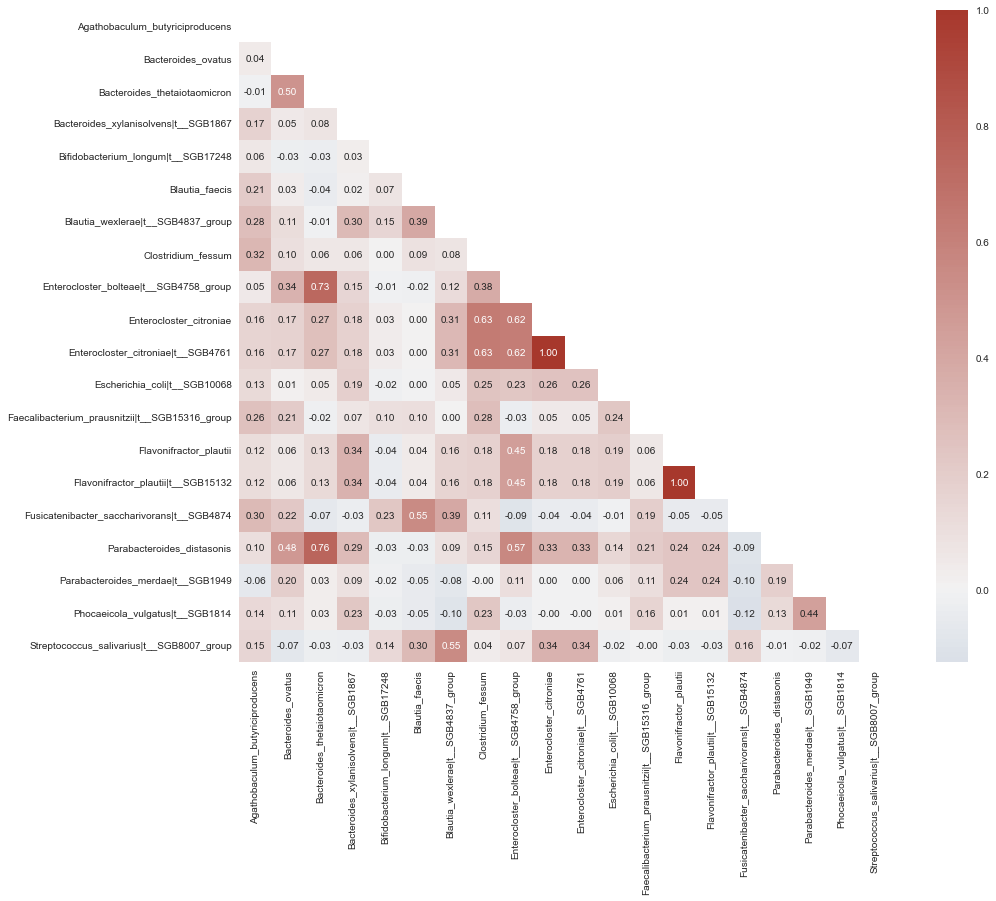

In [28]:
# pairwise correlation 
correlation_matrix(X_train_rf)

In [29]:
# drop highly related cols
cols = drop_cols(X_train_rf,.9)
cols

['Enterocloster_citroniae', 'Flavonifractor_plautii']

In [30]:
# drop the columns that are highly related
X_train_rf = X_train_rf.drop(cols, axis=1)
X_test_rf = X_test_rf.drop(cols, axis=1)
print('X train shape :', X_train_rf.shape)
print('X test shape :', X_test_rf.shape)

X train shape : (148, 18)
X test shape : (16, 18)


[LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


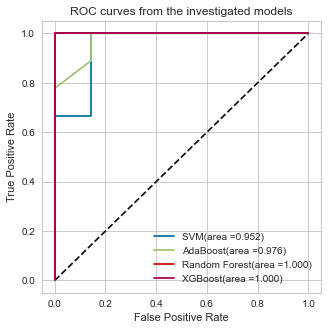

,Accuracy,Precision,Recall,Specificity,F1
SVM,0.9375,1.0,1.0,0.857143,0.947368
AdaBoost,0.9375,1.0,1.0,0.857143,0.947368
Random Forest,1.0000,1.0,1.0,1.000000,1.000000
XGBoost,0.9375,1.0,1.0,0.857143,0.947368


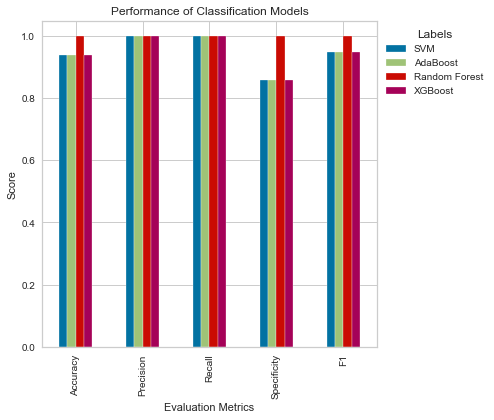

In [59]:
trainModels(X_train_rf,y_train_b, X_test_rf, y_test)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

,Accuracy Mean,Precision Mean,Recall Mean,Specificity Mean,F1 Mean
SVM,0.897619,0.907143,0.921556,0.8750,0.909884
AdaBoost,0.986190,0.973214,1.000000,0.9750,0.985641
Random Forest,0.972857,0.952381,1.000000,0.9375,0.974627
XGBoost,0.966190,0.956548,0.990909,0.9250,0.972598


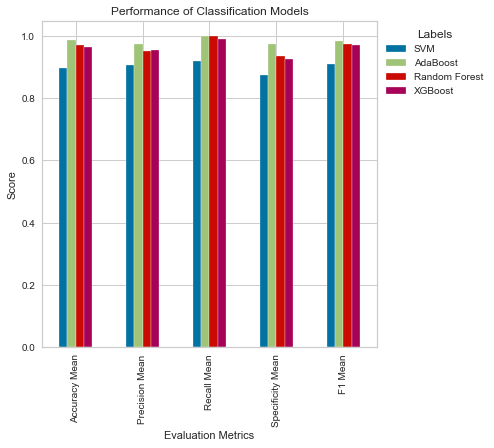

In [60]:
trainModelsCV(X_train_rf,y_train_b)

#### mRMR
https://towardsdatascience.com/mrmr-explained-exactly-how-you-wished-someone-explained-to-you-9cf4ed27458b

In [31]:
# select top 20 features using mRMR
mRMR_features = mrmr_classif(X=X_train_b, y=y_train_b, K=20)
mRMR_features

100%|██████████| 20/20 [00:41<00:00,  2.07s/it]


['Faecalibacterium_prausnitzii',
 'Ruminococcus_torques',
 'Harryflintia_acetispora',
 'Lachnospiraceae_bacterium_WCA3_601_WT_6H',
 'Mediterraneibacter_sp_gm002',
 'Clostridium_fessum',
 'Faecalibacterium_prausnitzii|t__SGB15316_group',
 'Dorea_formicigenerans',
 'Bilophila_wadsworthia',
 'Lachnospiraceae_bacterium',
 'Faecalibacterium_prausnitzii|t__SGB15342',
 'Bilophila_wadsworthia|t__SGB15452',
 'unclassified',
 'Dorea_formicigenerans|t__SGB4575',
 'Lachnospiraceae_bacterium|t__SGB4750',
 'Faecalibacterium_SGB15346',
 'Dysosmobacter_welbionis',
 'Clostridium_fessum|t__SGB4705',
 'Faecalibacterium_prausnitzii|t__SGB15318_group',
 'Clostridia_unclassified_SGB4121']

In [32]:
dfFeatures_mRMR = pd.DataFrame(mRMR_features)
dfFeatures_mRMR.columns = ['Features']
dfFeatures_mRMR.head()

,Features
0,Faecalibacterium_prausnitzii
1,Ruminococcus_torques
2,Harryflintia_acetispora
3,Lachnospiraceae_bacterium_WCA3_601_WT_6H
4,Mediterraneibacter_sp_gm002


In [33]:
# make the features as index
df_mRMR_20 = dfFeatures_mRMR.set_index(dfFeatures_mRMR.columns[0])

# get top 10  names
feat_names = df_mRMR_20.index
col_list = list(feat_names)

# drop the columns that are not in the list 
X_train_mRMR = X_train_b.drop(columns=[col for col in X_train_b if col not in col_list])
X_test_mRMR = X_test.drop(columns=[col for col in X_test if col not in col_list])
print('X train shape :', X_train_mRMR.shape)
print('X test shape :', X_test_mRMR.shape)

X train shape : (148, 20)
X test shape : (16, 20)


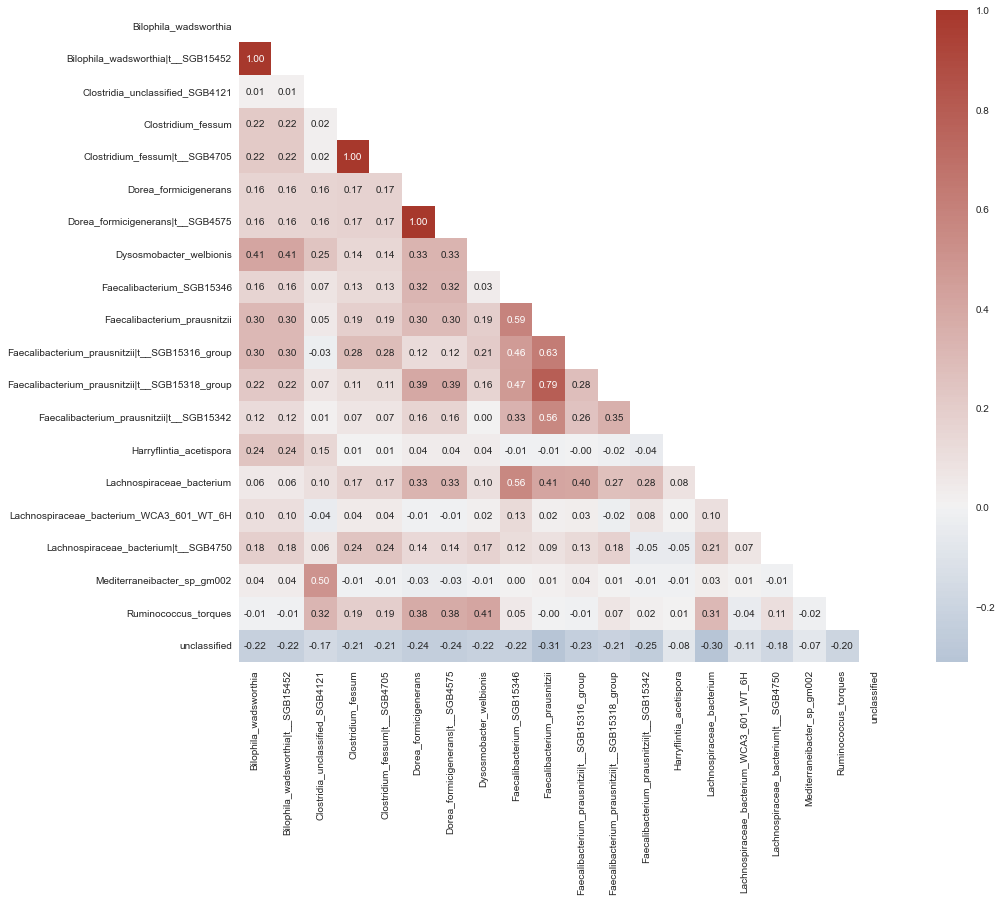

In [34]:
# pairwise correlation 
correlation_matrix(X_train_mRMR)

In [35]:
# drop highly related cols
cols = drop_cols(X_train_mRMR,.9)
cols

['Bilophila_wadsworthia', 'Clostridium_fessum', 'Dorea_formicigenerans']

In [36]:
# drop the columns that are highly related
X_train_mRMR = X_train_mRMR.drop(cols, axis=1)
X_test_mRMR = X_test_mRMR.drop(cols, axis=1)
print('X train shape :', X_train_mRMR.shape)
print('X test shape :', X_test_mRMR.shape)

X train shape : (148, 17)
X test shape : (16, 17)


[LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


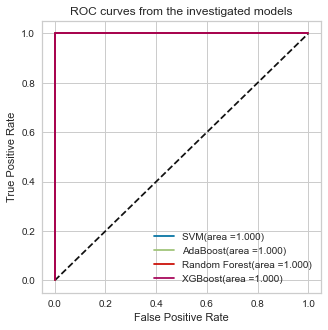

,Accuracy,Precision,Recall,Specificity,F1
SVM,0.6875,0.444444,0.444444,1.0,0.615385
AdaBoost,0.8125,0.666667,0.666667,1.0,0.800000
Random Forest,0.8750,0.777778,0.777778,1.0,0.875000
XGBoost,0.9375,0.888889,0.888889,1.0,0.941176


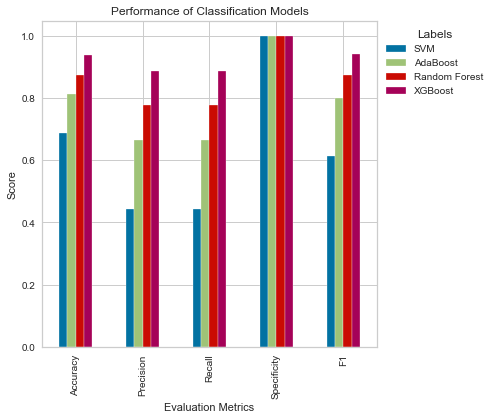

In [67]:
trainModels(X_train_mRMR,y_train_b, X_test_mRMR, y_test)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

,Accuracy Mean,Precision Mean,Recall Mean,Specificity Mean,F1 Mean
SVM,0.891429,0.919318,0.868021,0.913141,0.885721
AdaBoost,0.938571,0.955556,0.936941,0.945833,0.939768
Random Forest,0.946190,0.956421,0.956421,0.920833,0.955322
XGBoost,0.931905,0.945556,0.939755,0.920833,0.937820


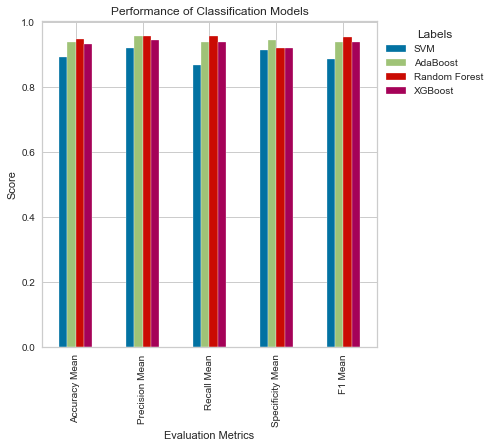

In [68]:
trainModelsCV(X_train_mRMR,y_train_b)

#### Lasso-based 
https://towardsdatascience.com/feature-selection-in-machine-learning-using-lasso-regression-7809c7c2771a

In [37]:
# lasso have to scale data
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

In [38]:
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

In [39]:
search.fit(X_train_b,y_train_b)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END .................model__alpha=0.1;, score=-0.109 total time=   0.2s
[CV 2/5] END .................model__alpha=0.1;, score=-0.100 total time=   0.1s
[CV 3/5] END .................model__alpha=0.1;, score=-0.112 total time=   0.1s
[CV 4/5] END .................model__alpha=0.1;, score=-0.142 total time=   0.1s
[CV 5/5] END .................model__alpha=0.1;, score=-0.117 total time=   0.3s
[CV 1/5] END .................model__alpha=0.2;, score=-0.172 total time=   0.1s
[CV 2/5] END .................model__alpha=0.2;, score=-0.218 total time=   0.2s
[CV 3/5] END .................model__alpha=0.2;, score=-0.190 total time=   0.1s
[CV 4/5] END .................model__alpha=0.2;, score=-0.204 total time=   0.1s
[CV 5/5] END .................model__alpha=0.2;, score=-0.216 total time=   0.1s
[CV 1/5] END .model__alpha=0.30000000000000004;, score=-0.249 total time=   0.1s
[CV 2/5] END .model__alpha=0.30000000000000004;

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error', verbose=3)

In [40]:
search.best_params_

{'model__alpha': 0.1}

In [41]:
coefficients = search.best_estimator_.named_steps['model'].coef_

In [42]:
importance = np.abs(coefficients)
importance

array([0., 0., 0., ..., 0., 0., 0.])

In [43]:
dfScores_Lasso = pd.DataFrame(importance)
dfColumns_Lasso = pd.DataFrame(X.columns)
dfFeatureScores_Lasso = pd.concat([dfColumns_Lasso,dfScores_Lasso],axis=1)
dfFeatureScores_Lasso.columns = ['Features','Score']
print('dfFeatureScores_Lasso :' ,dfFeatureScores_Lasso.shape)
dfFeatureScores_Lasso.head()

dfFeatureScores_Lasso : (5833, 2)


,Features,Score
0,Absicoccus_porci,0.0
1,Absicoccus_porci|t__SGB6818,0.0
2,Acidaminococcaceae_bacterium,0.0
3,Acidaminococcaceae_bacterium|t__SGB5789,0.0
4,Acidaminococcaceae_bacterium|t__SGB5790,0.0


In [44]:
# features taht are not equal to 0
df_Lasso = dfFeatureScores_Lasso[dfFeatureScores_Lasso['Score'] != 0]
df_Lasso

,Features,Score
271,Bacteroides_xylanisolvens,8.398604e-03
272,Bacteroides_xylanisolvens|t__SGB1867,3.600723e-17
299,Bilophila_wadsworthia,7.165968e-02
300,Bilophila_wadsworthia|t__SGB15452,1.200241e-16
317,Blautia_faecis,6.797582e-03
318,Blautia_faecis|t__SGB4820,1.200241e-17
699,Clostridia_unclassified_SGB4121,1.693714e-02
700,Clostridia_unclassified_SGB4121|t__SGB4121,4.800964e-17
791,Clostridium_fessum,3.131151e-02
947,Dorea_formicigenerans,5.312354e-02


DF shape : (20, 2)
                                            Features         Score
1101                    Faecalibacterium_prausnitzii  1.115668e-01
299                            Bilophila_wadsworthia  7.165968e-02
947                            Dorea_formicigenerans  5.312354e-02
1926                       Lachnospiraceae_bacterium  5.141141e-02
791                               Clostridium_fessum  3.131151e-02
2300                   Phascolarctobacterium_faecium  2.258577e-02
5792                                    unclassified  2.178706e-02
1962            Lachnospiraceae_bacterium|t__SGB4750  1.863502e-02
699                  Clostridia_unclassified_SGB4121  1.693714e-02
2527                            Ruminococcus_torques  1.653892e-02
1108        Faecalibacterium_prausnitzii|t__SGB15342  1.217797e-02
271                        Bacteroides_xylanisolvens  8.398604e-03
317                                   Blautia_faecis  6.797582e-03
1102  Faecalibacterium_prausnitzii|t__SGB15

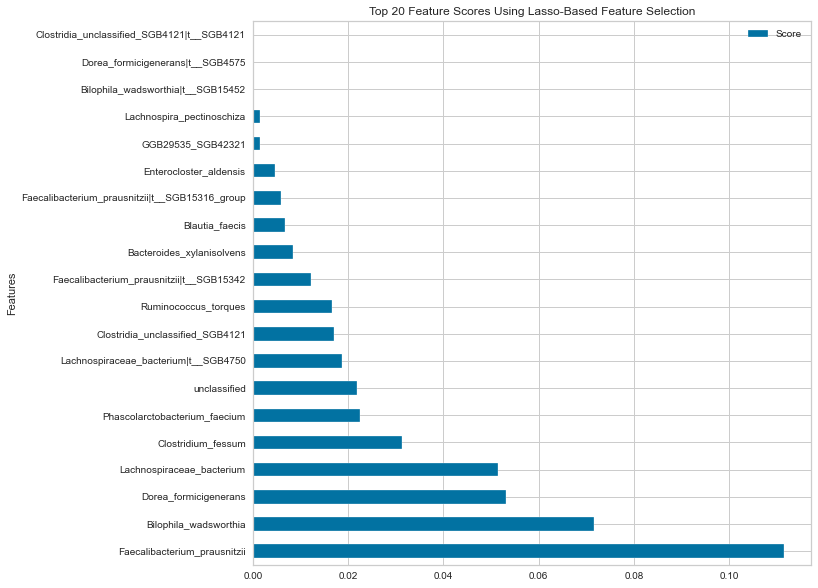

In [45]:
df_Lasso, X_train_Lasso, X_test_Lasso = topFeatures(df_Lasso, X_train_b, X_test, 2)

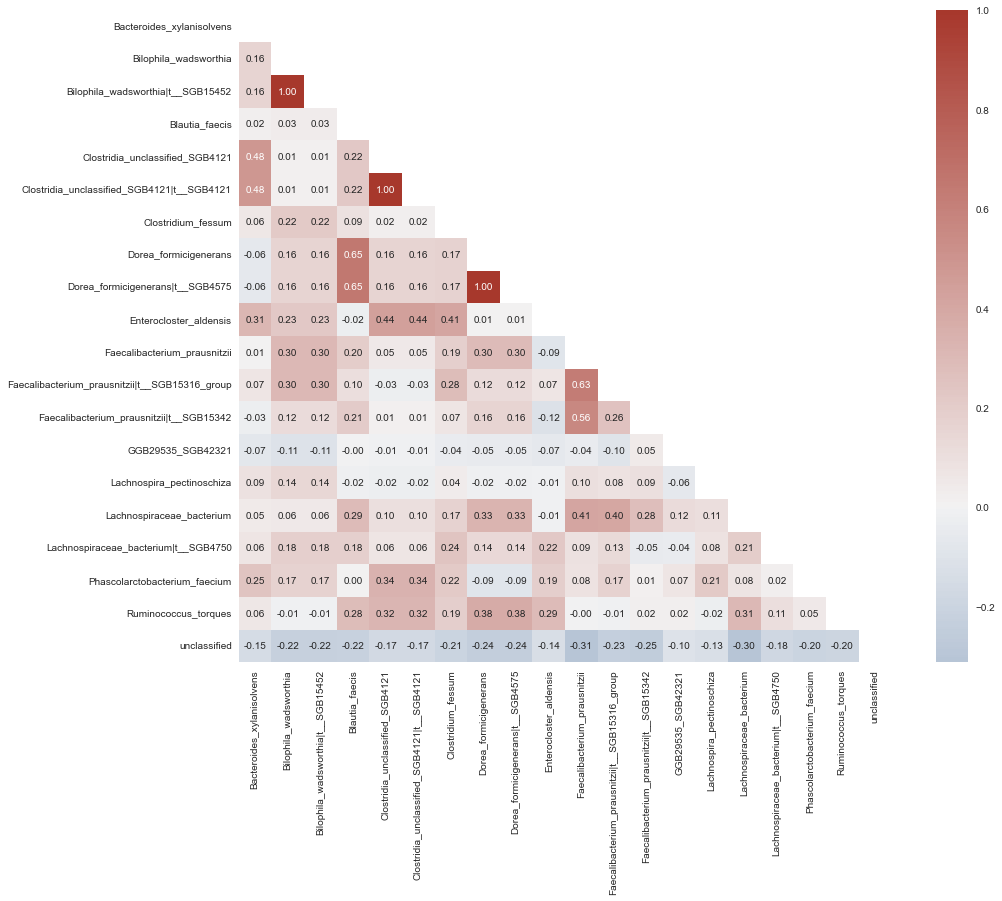

In [46]:
correlation_matrix(X_train_Lasso)

In [47]:
# drop highly related cols
cols = drop_cols(X_train_Lasso,0.9)
cols

['Bilophila_wadsworthia',
 'Clostridia_unclassified_SGB4121',
 'Dorea_formicigenerans']

In [48]:
# drop the columns that are highly related
X_train_Lasso = X_train_Lasso.drop(cols, axis=1)
X_test_Lasso = X_test_Lasso.drop(cols, axis=1)
print('X train shape :', X_train_Lasso.shape)
print('X test shape :', X_test_Lasso.shape)

X train shape : (148, 17)
X test shape : (16, 17)


[LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


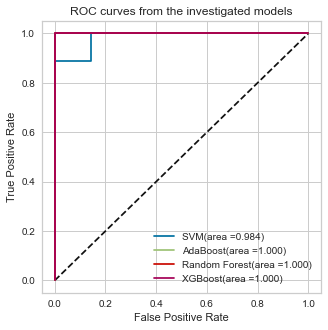

,Accuracy,Precision,Recall,Specificity,F1
SVM,0.6875,0.444444,0.444444,1.0,0.615385
AdaBoost,0.9375,0.888889,0.888889,1.0,0.941176
Random Forest,0.9375,0.888889,0.888889,1.0,0.941176
XGBoost,0.8750,0.777778,0.777778,1.0,0.875000


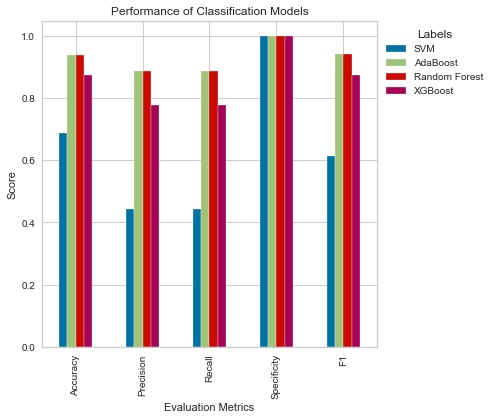

In [38]:
trainModels(X_train_Lasso, y_train_b, X_test_Lasso, y_test)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

,Accuracy Mean,Precision Mean,Recall Mean,Specificity Mean,F1 Mean
SVM,0.883810,0.887500,0.896953,0.871474,0.883973
AdaBoost,0.945714,0.942381,0.954762,0.920833,0.945034
Random Forest,0.952857,0.955032,0.967532,0.925000,0.959767
XGBoost,0.952381,0.956818,0.967532,0.925000,0.959840


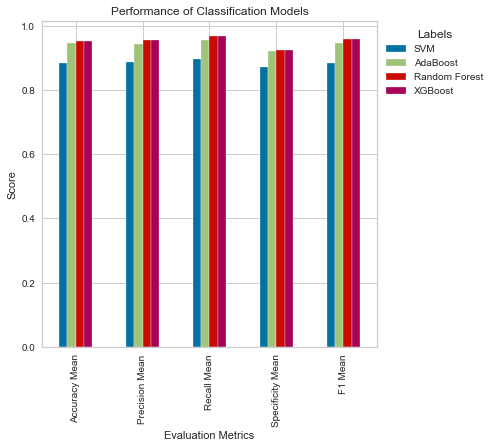

In [39]:
trainModelsCV(X_train_Lasso, y_train_b)

#### Elastic Net
https://www.kaggle.com/code/cast42/feature-selection-and-elastic-net/notebook

In [49]:
pipeline = Pipeline([
                     ('model',ElasticNet())
])

In [50]:
search = GridSearchCV(pipeline, 
                      {'model__alpha':np.arange(0.1,10,0.1),
                       'model__l1_ratio':[1.5, 1.1, 1, 0.9, 0.8, 0.7, 0.5]}, cv=2,
                        scoring='neg_mean_squared_error', verbose=3)

In [51]:
search.fit(X_train_b,y_train_b)

Fitting 2 folds for each of 693 candidates, totalling 1386 fits
[CV 1/2] END model__alpha=0.1, model__l1_ratio=1.5;, score=nan total time=   0.0s
[CV 2/2] END model__alpha=0.1, model__l1_ratio=1.5;, score=nan total time=   0.0s
[CV 1/2] END model__alpha=0.1, model__l1_ratio=1.1;, score=nan total time=   0.0s
[CV 2/2] END model__alpha=0.1, model__l1_ratio=1.1;, score=nan total time=   0.0s
[CV 1/2] END model__alpha=0.1, model__l1_ratio=1;, score=-0.098 total time=   0.1s
[CV 2/2] END model__alpha=0.1, model__l1_ratio=1;, score=-0.161 total time=   0.2s
[CV 1/2] END model__alpha=0.1, model__l1_ratio=0.9;, score=-0.097 total time=   0.3s
[CV 2/2] END model__alpha=0.1, model__l1_ratio=0.9;, score=-0.157 total time=   0.3s
[CV 1/2] END model__alpha=0.1, model__l1_ratio=0.8;, score=-0.101 total time=   0.2s
[CV 2/2] END model__alpha=0.1, model__l1_ratio=0.8;, score=-0.156 total time=   0.2s
[CV 1/2] END model__alpha=0.1, model__l1_ratio=0.7;, score=-0.111 total time=   0.2s
[CV 2/2] END mode

GridSearchCV(cv=2, estimator=Pipeline(steps=[('model', ElasticNet())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]),
                         'model__l1_ratio': [1.5, 1.1, 1, 0.9, 0.8, 0.7, 0.5]},
             scoring='neg_mean_squared_error', verbose=3)

In [52]:
search.best_params_

{'model__alpha': 0.1, 'model__l1_ratio': 0.9}

In [53]:
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)
importance

array([0., 0., 0., ..., 0., 0., 0.])

In [54]:
dfScores_EN = pd.DataFrame(importance)
dfColumns_EN = pd.DataFrame(X.columns)
dfFeatureScores_EN = pd.concat([dfColumns_EN,dfScores_EN],axis=1)
dfFeatureScores_EN.columns = ['Features','Score']
print('dfFeatureScores_EN :' ,dfFeatureScores_EN.shape)
dfFeatureScores_EN.head()

dfFeatureScores_EN : (5833, 2)


,Features,Score
0,Absicoccus_porci,0.0
1,Absicoccus_porci|t__SGB6818,0.0
2,Acidaminococcaceae_bacterium,0.0
3,Acidaminococcaceae_bacterium|t__SGB5789,0.0
4,Acidaminococcaceae_bacterium|t__SGB5790,0.0


In [55]:
# features taht are not equal to 0
df_EN = dfFeatureScores_EN[dfFeatureScores_EN['Score'] != 0]
df_EN

,Features,Score
210,Bacteroides_caccae,0.002588
211,Bacteroides_caccae|t__SGB1877,0.002505
212,Bacteroides_cellulosilyticus,0.014145
213,Bacteroides_cellulosilyticus|t__SGB1844,0.008506
228,Bacteroides_fragilis,0.008030
...,...,...
5681,putredinis,0.006511
5682,putredinis|t__SGB2318,0.003020
5792,unclassified,0.009775
5821,uniformis,0.001422


DF shape : (20, 2)
                                     Features     Score
1101             Faecalibacterium_prausnitzii  0.050334
2527                     Ruminococcus_torques  0.028271
348                          Blautia_wexlerae  0.015201
349         Blautia_wexlerae|t__SGB4837_group  0.014145
212              Bacteroides_cellulosilyticus  0.014145
5792                             unclassified  0.009775
213   Bacteroides_cellulosilyticus|t__SGB1844  0.008506
228                      Bacteroides_fragilis  0.008030
2304                    Phocaeicola_coprocola  0.006974
269                     Bacteroides_uniformis  0.006786
5650                           parainfluenzae  0.006525
5681                               putredinis  0.006511
2345                 Prevotella_copri_clade_A  0.005354
2305   Phocaeicola_coprocola|t__SGB1891_group  0.004942
1073                      Eubacterium_siraeum  0.004918
263                     Bacteroides_stercoris  0.004912
1049                         

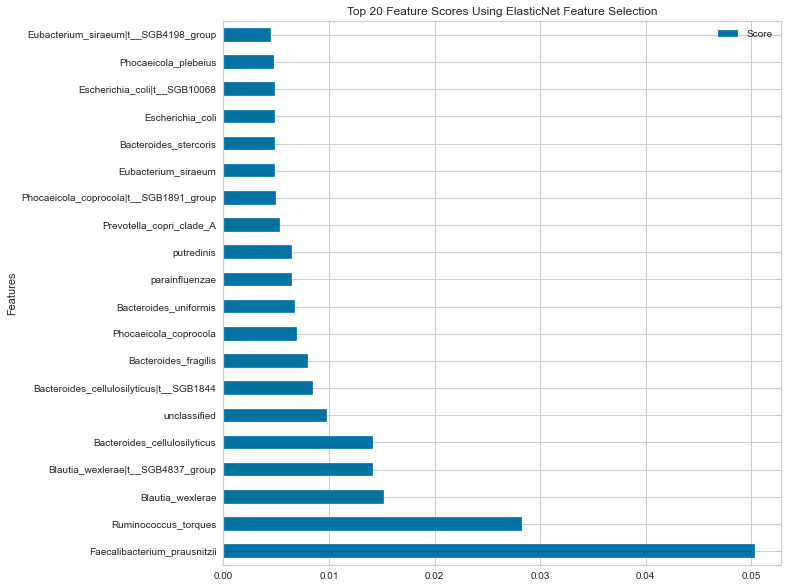

In [56]:
df_EN, X_train_EN, X_test_EN = topFeatures(df_EN, X_train_b, X_test, 3)

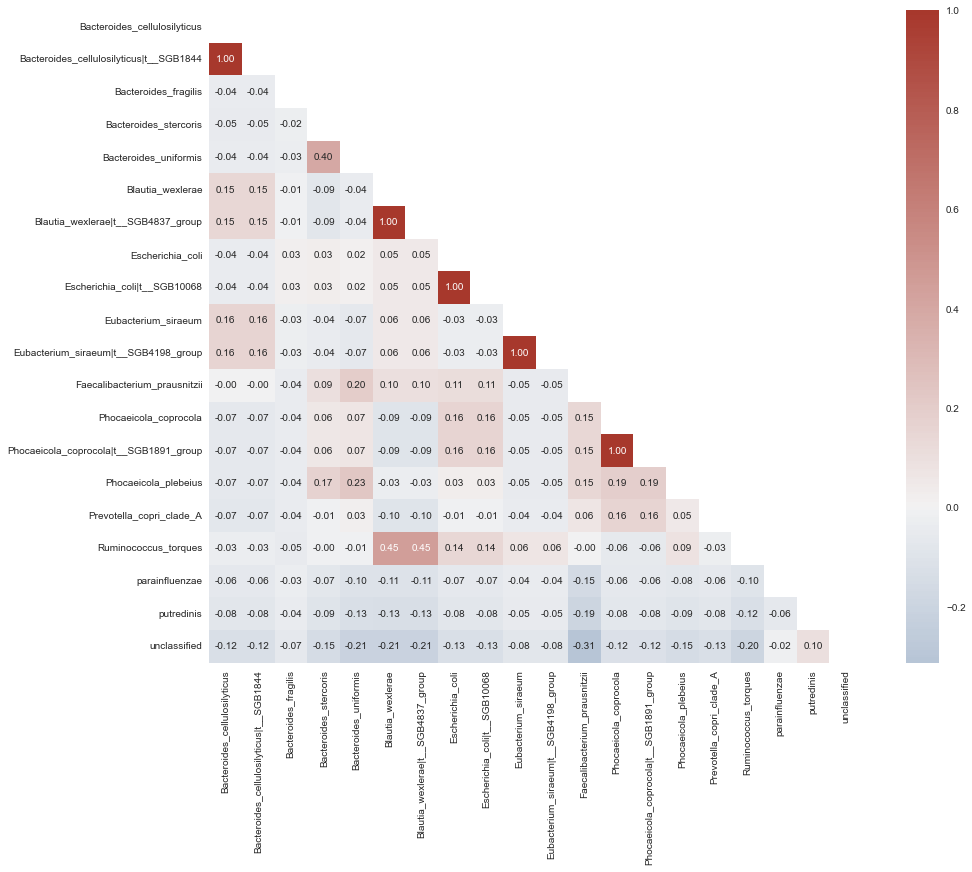

In [57]:
correlation_matrix(X_train_EN)

In [58]:
# drop highly related cols
cols = drop_cols(X_train_EN,0.9)
cols

['Bacteroides_cellulosilyticus',
 'Blautia_wexlerae',
 'Escherichia_coli',
 'Eubacterium_siraeum',
 'Phocaeicola_coprocola']

In [59]:
# drop the columns that are highly related
X_train_EN = X_train_EN.drop(cols, axis=1)
X_test_EN = X_test_EN.drop(cols, axis=1)
print('X train shape :', X_train_EN.shape)
print('X test shape :', X_test_EN.shape)

X train shape : (148, 15)
X test shape : (16, 15)


[LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


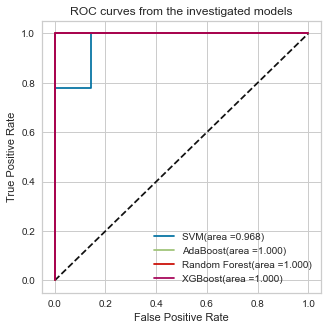

,Accuracy,Precision,Recall,Specificity,F1
SVM,0.8750,0.777778,0.777778,1.000000,0.875000
AdaBoost,0.9375,0.888889,0.888889,1.000000,0.941176
Random Forest,1.0000,1.000000,1.000000,1.000000,1.000000
XGBoost,0.9375,1.000000,1.000000,0.857143,0.947368


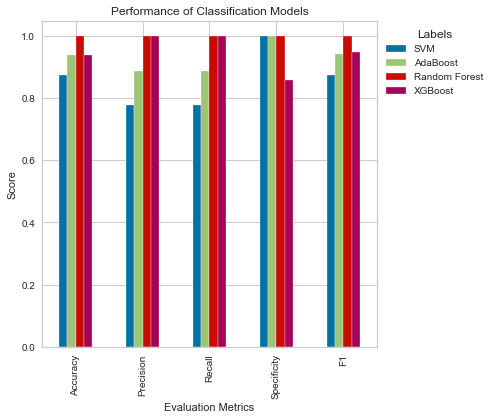

In [51]:
trainModels(X_train_EN, y_train_b, X_test_EN, y_test)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

,Accuracy Mean,Precision Mean,Recall Mean,Specificity Mean,F1 Mean
SVM,0.952857,0.954401,0.959957,0.937500,0.955032
AdaBoost,0.946190,0.924496,0.988889,0.883333,0.953697
Random Forest,0.946190,0.934325,0.979798,0.900000,0.954215
XGBoost,0.952857,0.944048,0.979798,0.912500,0.960049


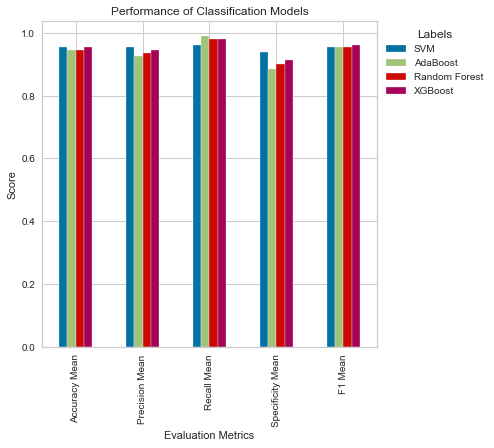

In [52]:
trainModelsCV(X_train_EN, y_train_b)

#### Intersection of Features

In [60]:
# save df as csv
X_train_EN.to_csv('X_train_EN.csv')
X_test_EN.to_csv('X_test_EN.csv')
X_train_Lasso.to_csv('X_train_Lasso.csv')
X_test_Lasso.to_csv('X_test_Lasso.csv')
X_train_rf.to_csv('X_train_rf.csv')
X_test_rf.to_csv('X_test_rf.csv')
X_train_mRMR.to_csv('X_train_mRMR.csv')
X_test_mRMR.to_csv('X_test_mRMR.csv')
X_train_skb.to_csv('X_train_skb.csv')
X_test_skb.to_csv('X_test_skb.csv')

In [61]:
#convert the columns to list
EN = X_train_EN.columns
Lasso = X_train_Lasso.columns
rf = X_train_rf.columns
mrmr = X_train_mRMR.columns
skb = X_train_skb.columns

In [62]:
print('EN :', EN)
print('Lasso :', Lasso)
print('RF :', rf)
print('mRMR :', mrmr)
print('skb :', skb)

EN : Index(['Bacteroides_cellulosilyticus|t__SGB1844', 'Bacteroides_fragilis',
       'Bacteroides_stercoris', 'Bacteroides_uniformis',
       'Blautia_wexlerae|t__SGB4837_group', 'Escherichia_coli|t__SGB10068',
       'Eubacterium_siraeum|t__SGB4198_group', 'Faecalibacterium_prausnitzii',
       'Phocaeicola_coprocola|t__SGB1891_group', 'Phocaeicola_plebeius',
       'Prevotella_copri_clade_A', 'Ruminococcus_torques', 'parainfluenzae',
       'putredinis', 'unclassified'],
      dtype='object')
Lasso : Index(['Bacteroides_xylanisolvens', 'Bilophila_wadsworthia|t__SGB15452',
       'Blautia_faecis', 'Clostridia_unclassified_SGB4121|t__SGB4121',
       'Clostridium_fessum', 'Dorea_formicigenerans|t__SGB4575',
       'Enterocloster_aldensis', 'Faecalibacterium_prausnitzii',
       'Faecalibacterium_prausnitzii|t__SGB15316_group',
       'Faecalibacterium_prausnitzii|t__SGB15342', 'GGB29535_SGB42321',
       'Lachnospira_pectinoschiza', 'Lachnospiraceae_bacterium',
       'Lachnospiraceae

In [63]:
# common elements for all
feat = list(set(EN). intersection(Lasso, rf, mrmr, skb))
print('All :' , feat)

All : []


In [64]:
# EN with three methods 

# without skb
feat = list(set(EN). intersection(Lasso, rf, mrmr))
print('EN without SKB :' , feat)

# without mrmr
feat = list(set(EN). intersection(Lasso, rf, skb))
print('EN without mrmr :' , feat)

# without rf
feat = list(set(EN). intersection(Lasso, mrmr, skb))
print('EN without rf :' , feat)

# without Lasso
feat = list(set(EN). intersection(rf, mrmr, skb))
print('EN without lasso :' , feat)

###################################################
# SKB with three methods 
print('\n')

# without en
feat = list(set(skb). intersection(Lasso, rf, mrmr))
print('SKB without EN :' , feat)

# without mrmr
feat = list(set(skb). intersection(Lasso, rf, EN))
print('SKB without mrmr :' , feat)

# without rf
feat = list(set(skb). intersection(Lasso, mrmr, EN))
print('SKB without rf :' , feat)

# without Lasso
feat = list(set(skb). intersection(rf, mrmr, EN))
print('SKB without lasso :' , feat)

###################################################
# MRMR with three methods 
print('\n')

# without en
feat = list(set(skb). intersection(Lasso, rf, mrmr))
print('MRMRwithout EN :' , feat)

# without skb
feat = list(set(mrmr). intersection(Lasso, rf, EN))
print('MRMR without SKB :' , feat)

# without rf
feat = list(set(skb). intersection(Lasso, mrmr, EN))
print('MRMR without rf :' , feat)

# without Lasso
feat = list(set(skb). intersection(rf, mrmr, EN))
print('MRMR without lasso :' , feat)

###################################################
# RF with three methods 
print('\n')

# without en
feat = list(set(skb). intersection(Lasso, rf, mrmr))
print('RF without EN :' , feat)

# without skb
feat = list(set(mrmr). intersection(Lasso, rf, EN))
print('RF without SKB :' , feat)

# without mrmr
feat = list(set(skb). intersection(Lasso, rf, EN))
print('RF without MRMR :' , feat)

# without Lasso
feat = list(set(skb). intersection(rf, mrmr, EN))
print('RF without lasso :' , feat)

###################################################
# Lasso with three methods 
print('\n')

# without en
feat = list(set(skb). intersection(Lasso, rf, mrmr))
print('Lasso without EN :' , feat)

# without skb
feat = list(set(mrmr). intersection(Lasso, rf, EN))
print('Lasso without SKB :' , feat)

# without mrmr
feat = list(set(skb). intersection(Lasso, rf, EN))
print('Lasso without MRMR :' , feat)

# without rf
feat = list(set(skb). intersection(Lasso, mrmr, EN))
print('Lasso without lasso :' , feat)



EN without SKB : []
EN without mrmr : []
EN without rf : ['Faecalibacterium_prausnitzii']
EN without lasso : []


SKB without EN : []
SKB without mrmr : []
SKB without rf : ['Faecalibacterium_prausnitzii']
SKB without lasso : []


MRMRwithout EN : []
MRMR without SKB : []
MRMR without rf : ['Faecalibacterium_prausnitzii']
MRMR without lasso : []


RF without EN : []
RF without SKB : []
RF without MRMR : []
RF without lasso : []


Lasso without EN : []
Lasso without SKB : []
Lasso without MRMR : []
Lasso without lasso : ['Faecalibacterium_prausnitzii']


In [65]:
# EN with two methods 

# EN with Lasso, skb
feat = list(set(EN).intersection(Lasso,skb))
print('EN with Lasso | SKB :' , feat)

# EN with Lasso, mRMR
feat = list(set(EN).intersection(Lasso, mrmr))
print('EN with Lasso | mRMR :' , feat)

# EN with Lasso, RF
feat = list(set(EN).intersection(Lasso, rf))
print('EN with Lasso | rf :' , feat)

# EN with skb, RF
feat = list(set(EN).intersection(rf))
print('EN with SKB | rf :' , feat)

# EN with skb, mrmr
feat = list(set(EN).intersection(rf))
print('EN with SKB | mrmr :' , feat)

# EN with mrm, rf
feat = list(set(EN).intersection(rf))
print('EN with rf | mrmr :' , feat)

###################################################
# rf with two methods

# rf with Lasso, skb
feat = list(set(rf).intersection(Lasso,skb))
print('RF with Lasso | SKB :' , feat)

# rf with Lasso, mRMR
feat = list(set(rf).intersection(Lasso, mrmr))
print('RF with Lasso | mRMR :' , feat)

# EN with skb, mrmr
feat = list(set(rf).intersection(rf))
print('RF with SKB | mrmr :' , feat)

###################################################
# skb with two methods

# skb with Lasso, mRMR
feat = list(set(skb).intersection(Lasso, mrmr))
print('SKB with Lasso | mRMR :' , feat)


EN with Lasso | SKB : ['Faecalibacterium_prausnitzii']
EN with Lasso | mRMR : ['Ruminococcus_torques', 'Faecalibacterium_prausnitzii', 'unclassified']
EN with Lasso | rf : []
EN with SKB | rf : ['Escherichia_coli|t__SGB10068', 'Blautia_wexlerae|t__SGB4837_group']
EN with SKB | mrmr : ['Escherichia_coli|t__SGB10068', 'Blautia_wexlerae|t__SGB4837_group']
EN with rf | mrmr : ['Escherichia_coli|t__SGB10068', 'Blautia_wexlerae|t__SGB4837_group']
RF with Lasso | SKB : []
RF with Lasso | mRMR : ['Faecalibacterium_prausnitzii|t__SGB15316_group']
RF with SKB | mrmr : ['Bifidobacterium_longum|t__SGB17248', 'Streptococcus_salivarius|t__SGB8007_group', 'Parabacteroides_merdae|t__SGB1949', 'Enterocloster_citroniae|t__SGB4761', 'Fusicatenibacter_saccharivorans|t__SGB4874', 'Bacteroides_ovatus', 'Parabacteroides_distasonis', 'Bacteroides_xylanisolvens|t__SGB1867', 'Escherichia_coli|t__SGB10068', 'Agathobaculum_butyriciproducens', 'Blautia_faecis', 'Enterocloster_bolteae|t__SGB4758_group', 'Flavonifra

In [66]:
# EN with one method

# EN with Lasso
feat = list(set(EN).intersection(Lasso))
print('EN with Lasso :' , feat)

# EN with skb
feat = list(set(EN).intersection(skb))
print('EN with skb :' , feat)

# EN with mrmr
feat = list(set(EN).intersection(mrmr))
print('EN with mRMR :' , feat)

# EN with rf
feat = list(set(EN).intersection(rf))
print('EN with rf :' , feat)

###################################################
# rf with one method
print('\n')

# rf with Lasso
feat = list(set(rf).intersection(Lasso))
print('RF with Lasso :' , feat)

# rf with skb
feat = list(set(rf).intersection(skb))
print('RF with skb :' , feat)

# rf with mrmr
feat = list(set(rf).intersection(mrmr))
print('RF with mRMR :' , feat)

###################################################
# MRMR with one method
print('\n')

# mrmr with Lasso
feat = list(set(mrmr).intersection(Lasso))
print('mRMR with Lasso :' , feat)

# mrmr with skb
feat = list(set(mrmr).intersection(skb))
print('mRMR with skb :' , feat)

###################################################
# skb with one method
print('\n')

# skb with Lasso
feat = list(set(skb).intersection(Lasso))
print('SKB with Lasso :' , feat)


EN with Lasso : ['Ruminococcus_torques', 'Faecalibacterium_prausnitzii', 'unclassified']
EN with skb : ['Bacteroides_fragilis', 'Faecalibacterium_prausnitzii']
EN with mRMR : ['Ruminococcus_torques', 'Faecalibacterium_prausnitzii', 'unclassified']
EN with rf : ['Escherichia_coli|t__SGB10068', 'Blautia_wexlerae|t__SGB4837_group']


RF with Lasso : ['Faecalibacterium_prausnitzii|t__SGB15316_group', 'Blautia_faecis', 'Clostridium_fessum']
RF with skb : []
RF with mRMR : ['Faecalibacterium_prausnitzii|t__SGB15316_group']


mRMR with Lasso : ['Faecalibacterium_prausnitzii|t__SGB15342', 'Faecalibacterium_prausnitzii', 'Bilophila_wadsworthia|t__SGB15452', 'Ruminococcus_torques', 'Lachnospiraceae_bacterium', 'unclassified', 'Faecalibacterium_prausnitzii|t__SGB15316_group', 'Dorea_formicigenerans|t__SGB4575', 'Lachnospiraceae_bacterium|t__SGB4750']
mRMR with skb : ['Faecalibacterium_prausnitzii']


SKB with Lasso : ['Faecalibacterium_prausnitzii']


### Unsupervised Learning

In [69]:
### function to get cols names to list
unionList = []
def getColNames(df):
    cols = df.columns.values.tolist()
    for i in range(len(cols)) :
        unionList.append(cols[i])

getColNames(X_train_EN)
getColNames(X_train_Lasso)
getColNames(X_train_rf)
getColNames(X_train_mRMR)
getColNames(X_train_skb)
print('Total Number of Features :', len(unionList))

Total Number of Features : 78


In [70]:
# read diabetes and healthy file separately
# drop cols
# cluster separately

df_diabetes = pd.read_csv(r'D:\FYP\df_T2D.csv')
df_healthy = pd.read_csv(r'D:\FYP\df_H.csv')
print('Diabetes df shape :', df_diabetes.shape)
print('Healthy df shape :', df_healthy.shape)

Diabetes df shape : (70, 2666)
Healthy df shape : (82, 4153)


In [71]:
# drop cols taht are not in the union list
df_d = df_diabetes.drop(columns=[col for col in df_diabetes if col not in unionList])
df_h = df_healthy.drop(columns=[col for col in df_healthy if col not in unionList])
print('Diabetes df shape :', df_d.shape)
print('Healthy df shape :', df_h.shape)

Diabetes df shape : (70, 49)
Healthy df shape : (82, 54)


#### K-Means Function
https://www.kaggle.com/code/shrutimechlearn/step-by-step-kmeans-explained-in-detail 

visualizer --> https://www.kaggle.com/code/residentmario/ml-visualization-with-yellowbrick-3
https://towardsdatascience.com/silhouette-method-better-than-elbow-method-to-find-optimal-clusters-378d62ff6891

In [72]:
# elbow plot
def elbowAndSilhouette(df):
    wcss = []
    silhouette = []
    cluster_range = [2,3,4,5,6,7,8,9]
    #fig, ax = plt.subplots(2, 2, figsize=(15,8))
    for i in cluster_range:
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        cluster_labels = kmeans.labels_
        silhouette.append(silhouette_score(df, cluster_labels))
        #print('For cluster {0}, silhouette score is {1}'.format(i,silhouette))

        #plot silhouette visualizer
        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
        visualizer.fit(df)
        visualizer.poof()

    # plot elbow graph
    plt.figure(figsize=(6,6))
    sns.lineplot(range(2,10), wcss, marker='o', color='red')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

    # plot silhouette graph
    plt.plot(cluster_range, silhouette,'bx-')
    plt.title('Silhouette Analysis')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()


# FUNCTION to sum the features for each cluster
# df_d, y_kmeans, total number of clusters
def stackedBar(df, y_kmeans, n):
    df_d_cluster = df.copy()
    sum_cols = pd.DataFrame(index=df_d_cluster.columns)
    df_d_cluster['Cluster'] = y_kmeans
    
    for i in range(n):
        df_cluster = df_d_cluster[df_d_cluster['Cluster'] == i].copy()
        df_cluster.drop(['Cluster'], axis=1)
        sum_cols[str(i)] = df_cluster.sum(axis=0) 
    sum_cols_t = sum_cols.transpose()
    sum_cols_t['Cluster'] = sum_cols_t.index

    dict = {}
    for i in range(n):
        dict['df_{0}'.format(i)] = sum_cols.nlargest(5, str(i)) 

    # plot stacked graph

    plt.rcParams["figure.figsize"] = (15,10)
    sum_cols_t.plot.bar(x='Cluster',stacked=True,rot=15, title="Species in the Clusters")
    plt.legend(bbox_to_anchor=(1.0, 1.0), title='Species')
    plt.show(block=True)
    return dict


#### Hierarchical Clustering Function

https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/

In [73]:
def hierarchicalFirst(df):
    df_scaled_d = normalize(df)
    df_scaled_d = pd.DataFrame(df_scaled_d, columns=df.columns)

    # plot dendogram
    plt.figure(1, figsize = (16 ,8))
    dendrogram = sch.dendrogram(sch.linkage(df_scaled_d, method  = "ward"))
    plt.title('Dendrogram')
    plt.xlabel('Species')
    plt.ylabel('Euclidean distances')
    plt.show()
    return df_scaled_d

def hierarchicalSecond(df,y):
    # plot dendogram with threshold
    plt.figure(1, figsize = (16 ,8))
    dendrogram = sch.dendrogram(sch.linkage(df, method  = "ward"))
    plt.title('Dendrogram')
    plt.xlabel('Species')
    plt.ylabel('Euclidean distances')
    plt.axhline(y=y, color='r', linestyle='--') # to show the threshold, can be removed
    plt.show()

def agglomerative(df, n):
    cluster = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    predict = cluster.fit_predict(df)
    return predict

#### Union

##### Diabetes

Kmeans

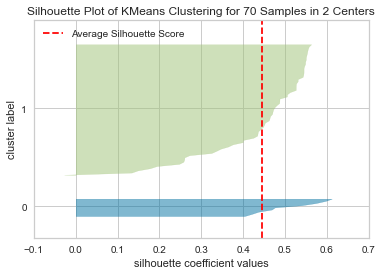

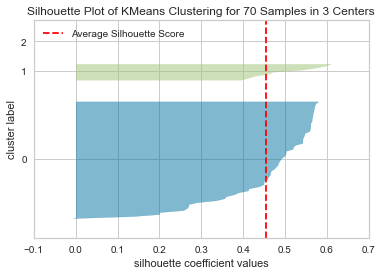

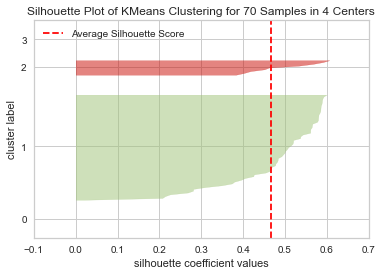

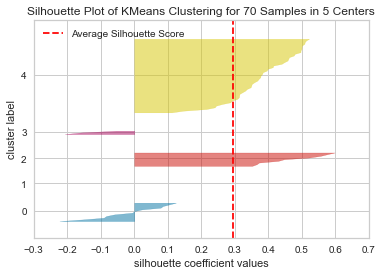

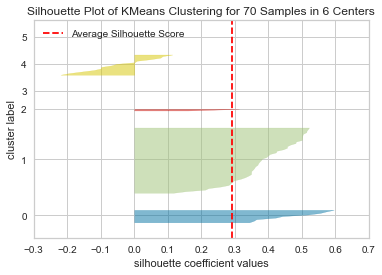

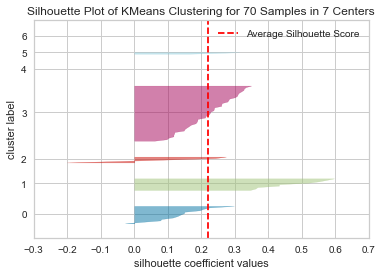

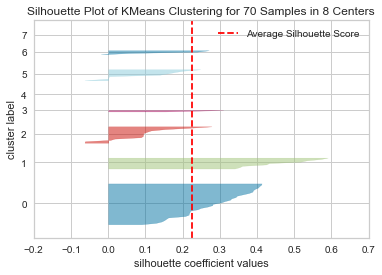

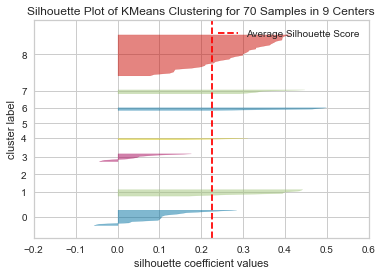

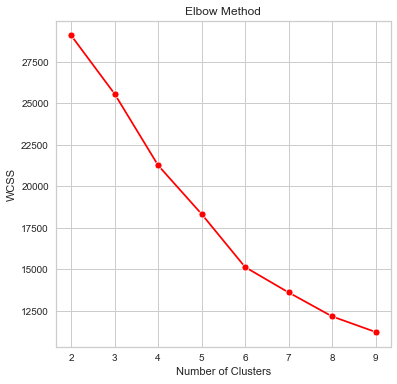

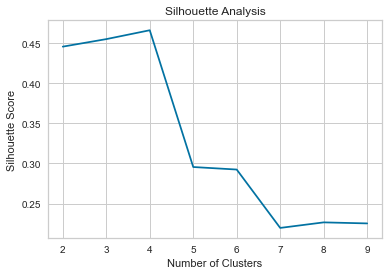

In [74]:
# for diabetes df
elbowAndSilhouette(df_d)

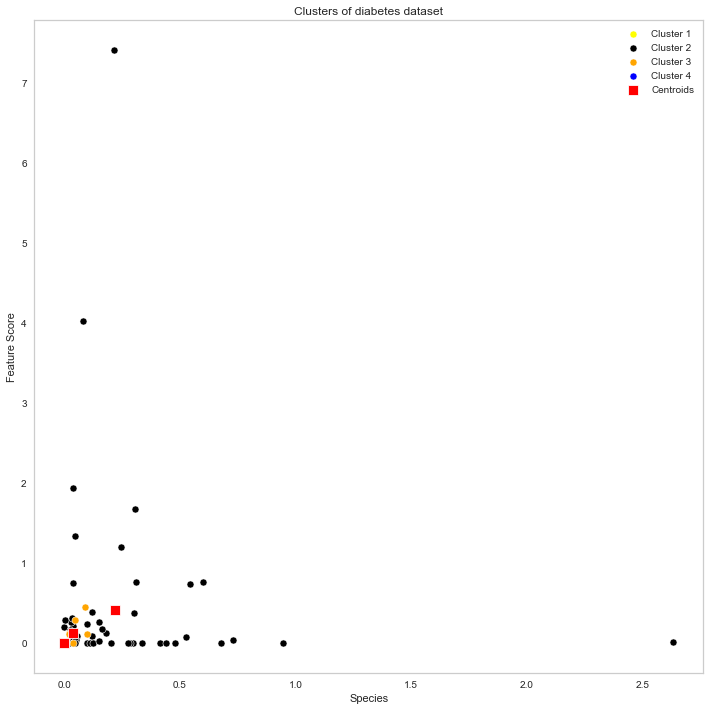

In [76]:
# applying k means = 4
X = df_d.to_numpy() # have to convert to numpy to plot graph
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X)

plt.figure(figsize=(12,12))
sns.scatterplot(X[y_kmeans == 0,0], X[y_kmeans == 0,1], color = 'yellow', label ='Cluster 1', s=50)
sns.scatterplot(X[y_kmeans == 1,0], X[y_kmeans == 1,1], color = 'black', label ='Cluster 2', s=50)
sns.scatterplot(X[y_kmeans == 2,0], X[y_kmeans == 2,1], color = 'orange', label ='Cluster 3', s=50)
sns.scatterplot(X[y_kmeans == 3,0], X[y_kmeans == 3,1], color = 'blue', label ='Cluster 4', s=50)
#sns.scatterplot(X[y_kmeans == 4,0], X[y_kmeans == 4,1], color = 'green', label ='Cluster 5', s=50)
#sns.scatterplot(X[y_kmeans == 5,0], X[y_kmeans == 5,1], color = 'grey', label ='Cluster 6', s=50)
sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color ='red', label='Centroids', s=100, marker=',')
plt.grid(False)
plt.title('Clusters of diabetes dataset')
plt.xlabel('Species')
plt.ylabel('Feature Score')
plt.legend()
plt.show()

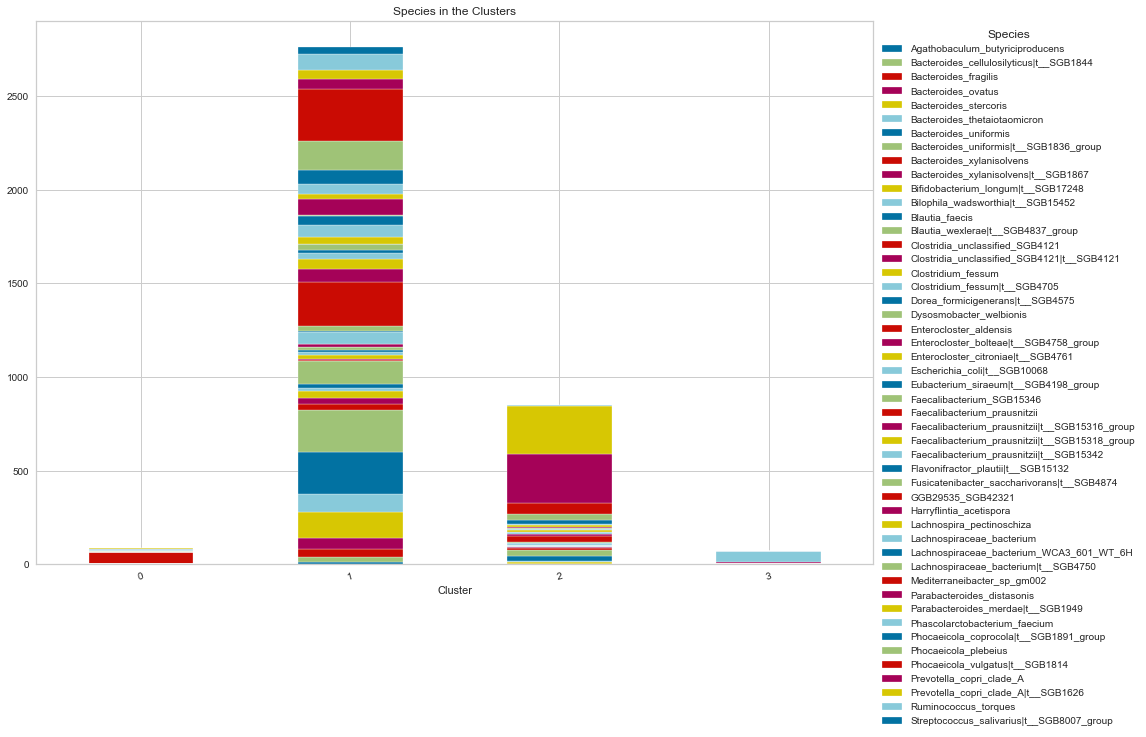

In [77]:
dict_cluster = stackedBar(df_d, y_kmeans, 4)

In [78]:
# species of cluster 1
print('Cluster 0 : ')
display(dict_cluster['df_0'])
print('Cluster 1 : ')
display(dict_cluster['df_1'])
print('Cluster 2 : ')
display(dict_cluster['df_2'])
print('Cluster 3 : ')
display(dict_cluster['df_3'])

Cluster 0 : 


,0,1,2,3
Bacteroides_fragilis,66.41921,46.68379,0.38742,0.11519
Phocaeicola_vulgatus|t__SGB1814,4.19831,276.39216,59.74521,0.32949
Faecalibacterium_prausnitzii,1.79423,237.94809,30.61291,0.00000
Faecalibacterium_prausnitzii|t__SGB15316_group,1.79423,68.34004,11.47440,0.00000
Clostridium_fessum,1.63027,19.07058,2.06841,0.00000


Cluster 1 : 


,0,1,2,3
Phocaeicola_vulgatus|t__SGB1814,4.19831,276.39216,59.74521,0.32949
Faecalibacterium_prausnitzii,1.79423,237.94809,30.61291,0.00000
Bacteroides_uniformis,0.27809,223.86778,30.03574,0.01840
Bacteroides_uniformis|t__SGB1836_group,0.27809,223.86778,30.03574,0.01840
Phocaeicola_plebeius,0.00900,158.28502,33.07457,0.00707


Cluster 2 : 


,0,1,2,3
Prevotella_copri_clade_A,0.09890,51.38275,258.37371,0.02038
Prevotella_copri_clade_A|t__SGB1626,0.09890,51.38275,258.37371,0.02038
Phocaeicola_vulgatus|t__SGB1814,4.19831,276.39216,59.74521,0.32949
Phocaeicola_plebeius,0.00900,158.28502,33.07457,0.00707
Faecalibacterium_prausnitzii,1.79423,237.94809,30.61291,0.00000


Cluster 3 : 


,0,1,2,3
Escherichia_coli|t__SGB10068,0.64741,62.05816,8.61047,59.21869
Enterocloster_bolteae|t__SGB4758_group,1.07529,14.75575,0.15998,10.02534
Phocaeicola_vulgatus|t__SGB1814,4.19831,276.39216,59.74521,0.32949
Clostridia_unclassified_SGB4121,0.03368,5.72167,0.28250,0.17028
Clostridia_unclassified_SGB4121|t__SGB4121,0.03368,5.72167,0.28250,0.17028


Hierarchical Clustering

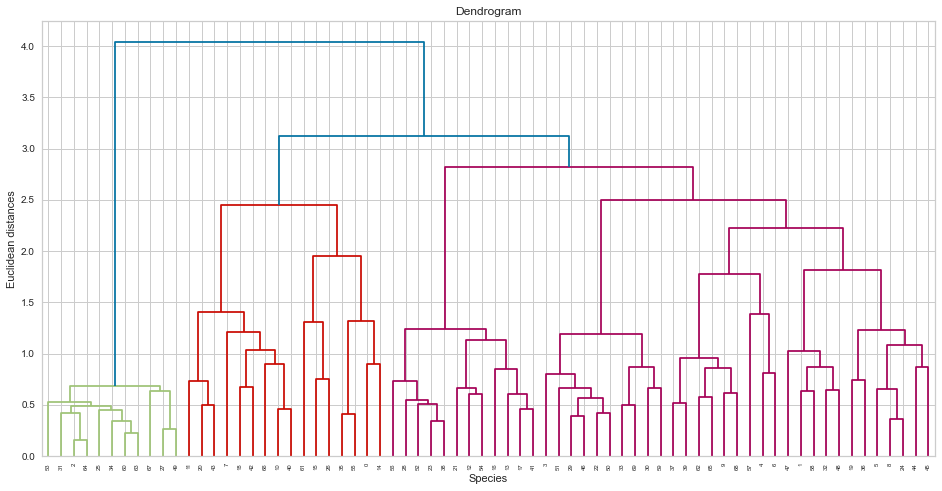

In [79]:
df_scaled_d = hierarchicalFirst(df_d)

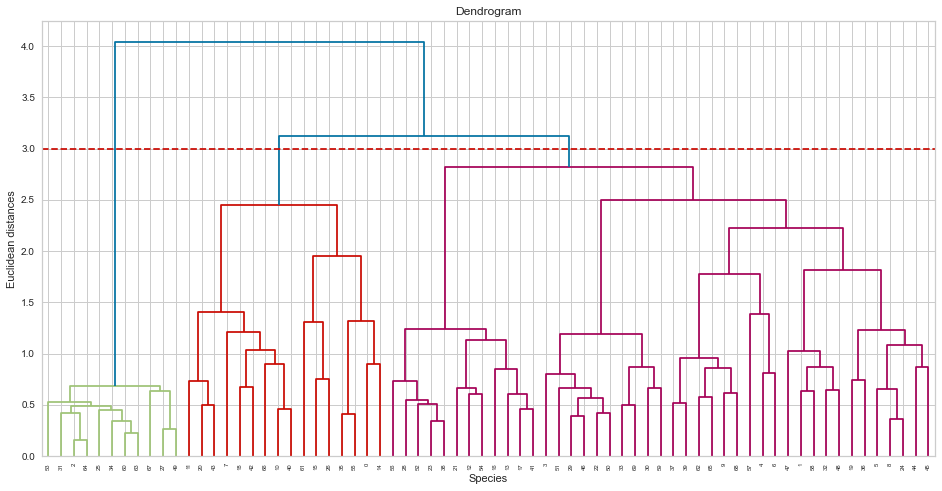

In [80]:
hierarchicalSecond(df_scaled_d,3.0)

In [81]:
y_hc = agglomerative(df_scaled_d, 3)
y_hc

array([2, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0,
       0, 0, 0, 1, 2, 1, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 2, 2,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 1, 2, 0, 1, 1, 0,
       2, 1, 0, 0], dtype=int64)

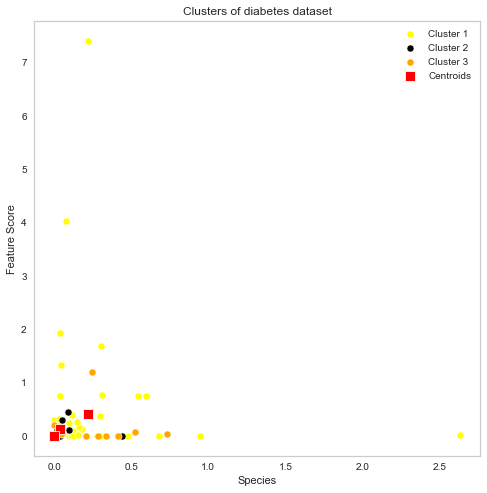

In [82]:
# agglomerative clustering = 3
X = df_d.to_numpy() # have to convert to numpy to plot graph

plt.figure(figsize=(8,8))
sns.scatterplot(X[y_hc == 0,0], X[y_hc == 0,1], color = 'yellow', label ='Cluster 1', s=50)
sns.scatterplot(X[y_hc == 1,0], X[y_hc == 1,1], color = 'black', label ='Cluster 2', s=50)
sns.scatterplot(X[y_hc == 2,0], X[y_hc == 2,1], color = 'orange', label ='Cluster 3', s=50)
#sns.scatterplot(X[y_hc == 3,0], X[y_hc == 3,1], color = 'blue', label ='Cluster 4', s=50)
#sns.scatterplot(X[y_kmeans == 4,0], X[y_kmeans == 4,1], color = 'green', label ='Cluster 5', s=50)
#sns.scatterplot(X[y_kmeans == 5,0], X[y_kmeans == 5,1], color = 'grey', label ='Cluster 6', s=50)
sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color ='red', label='Centroids', s=100, marker=',')
plt.grid(False)
plt.title('Clusters of diabetes dataset')
plt.xlabel('Species')
plt.ylabel('Feature Score')
plt.legend()
plt.show()

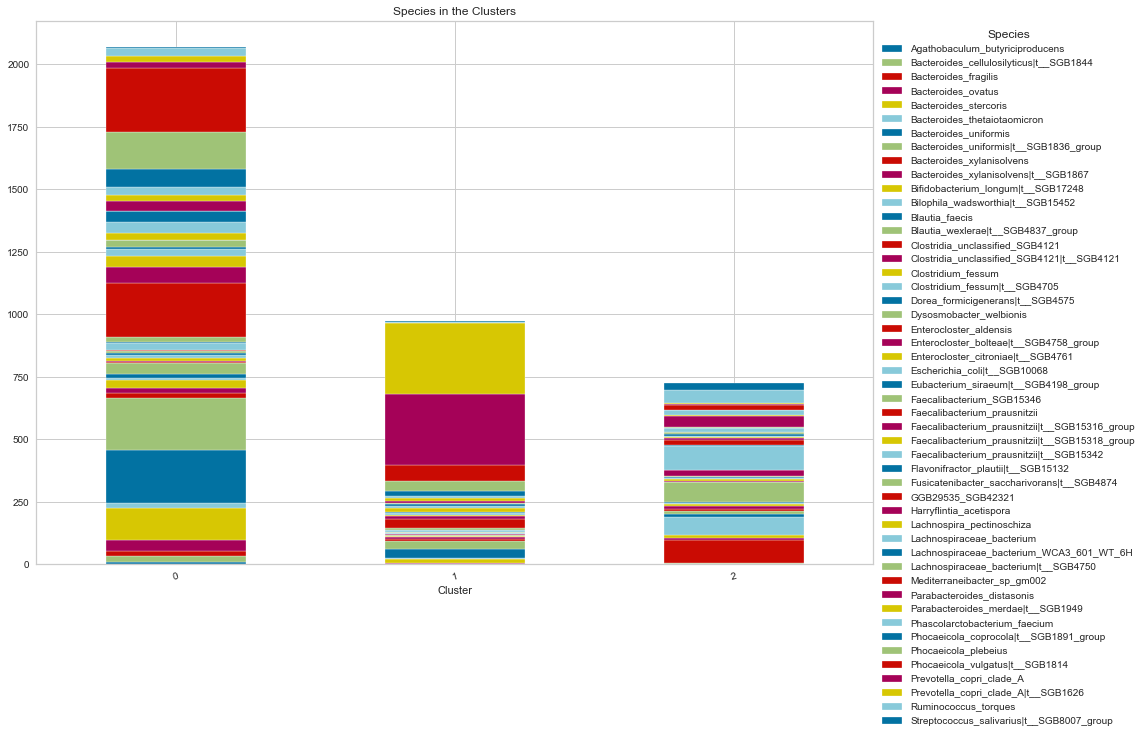

In [83]:
dict_cluster = stackedBar(df_d, y_hc, 3)

In [85]:
# species of cluster 1
print('Cluster 0 : ')
display(dict_cluster['df_0'])
print('Cluster 1 : ')
display(dict_cluster['df_1'])
print('Cluster 2 : ')
display(dict_cluster['df_2'])

Cluster 0 : 


,0,1,2
Phocaeicola_vulgatus|t__SGB1814,257.29336,64.30493,19.06688
Faecalibacterium_prausnitzii,215.66017,35.53773,19.15733
Bacteroides_uniformis,208.93618,34.34825,10.91558
Bacteroides_uniformis|t__SGB1836_group,208.93618,34.34825,10.91558
Phocaeicola_plebeius,148.94097,41.39714,1.03755


Cluster 1 : 


,0,1,2
Prevotella_copri_clade_A,23.06124,282.33977,4.47473
Prevotella_copri_clade_A|t__SGB1626,23.06124,282.33977,4.47473
Phocaeicola_vulgatus|t__SGB1814,257.29336,64.30493,19.06688
Phocaeicola_plebeius,148.94097,41.39714,1.03755
Faecalibacterium_prausnitzii,215.66017,35.53773,19.15733


Cluster 2 : 


,0,1,2
Escherichia_coli|t__SGB10068,25.02168,8.78892,96.72413
Bacteroides_fragilis,21.56064,0.38742,91.65755
Blautia_wexlerae|t__SGB4837_group,46.32608,3.73550,76.82358
Bacteroides_thetaiotaomicron,21.84511,5.53333,73.58529
Ruminococcus_torques,31.15110,6.62564,51.50121


##### Healthy

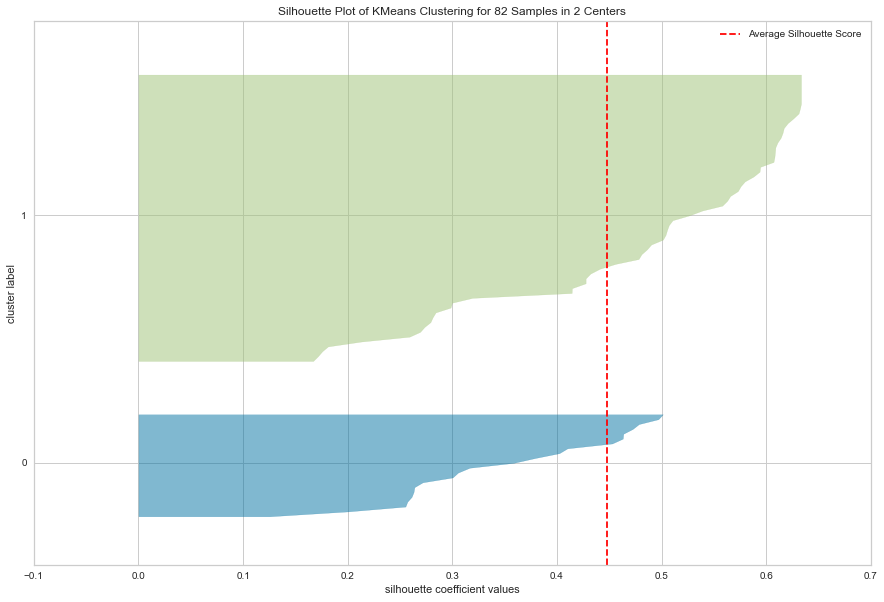

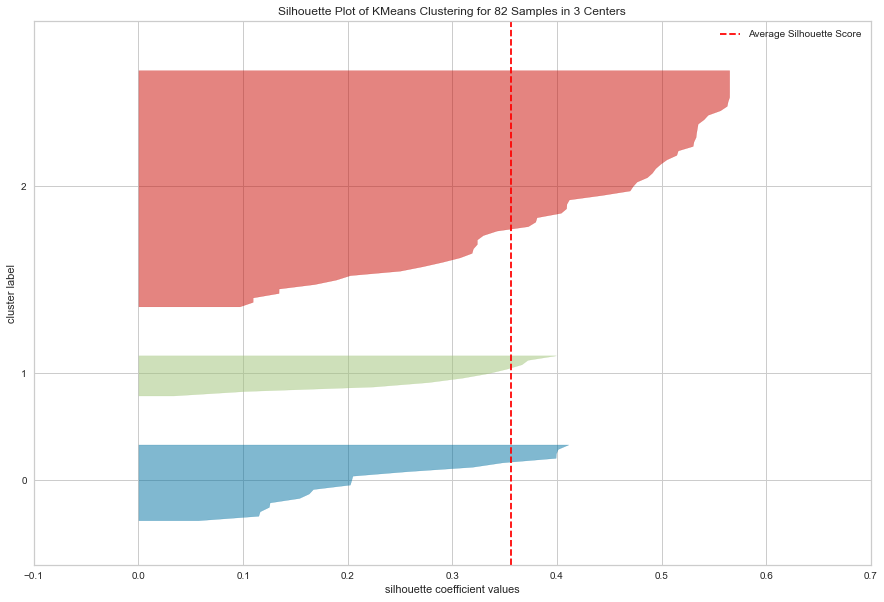

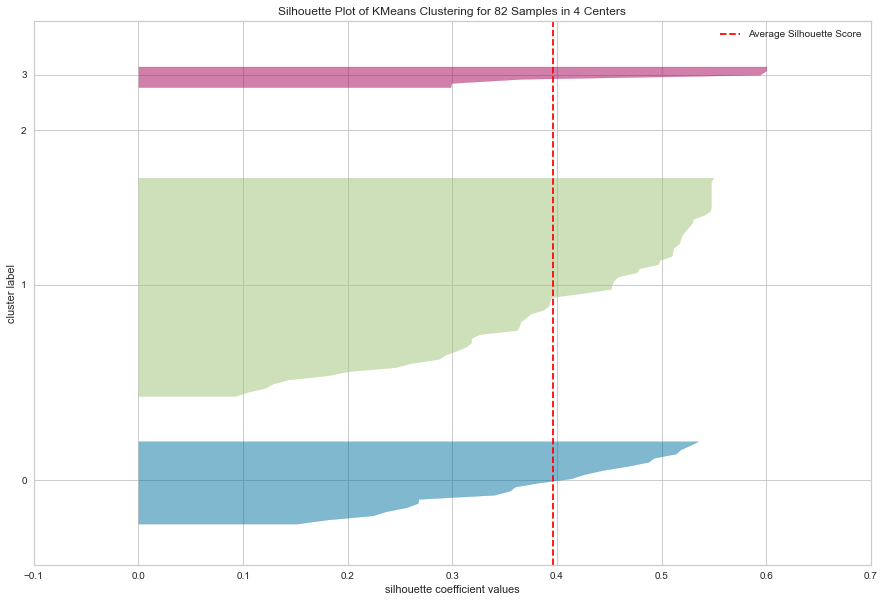

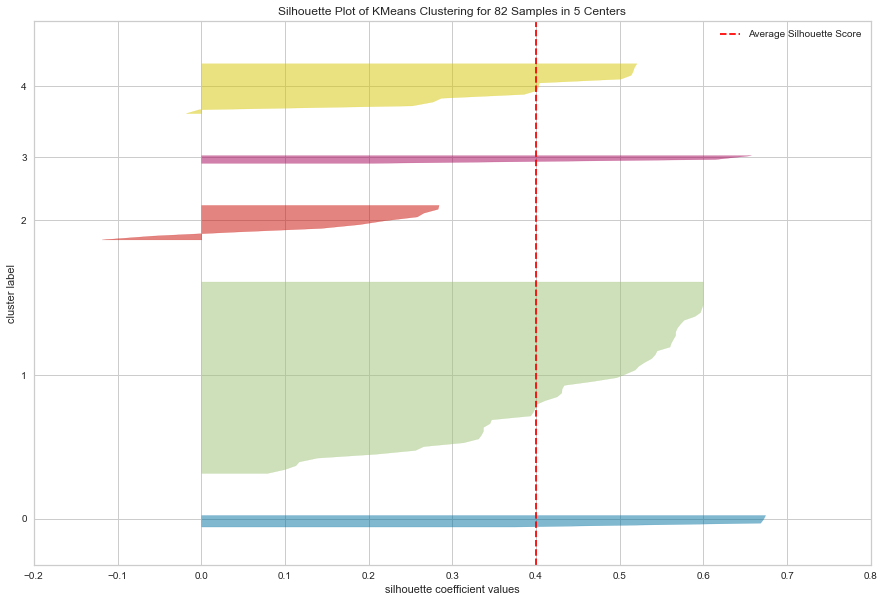

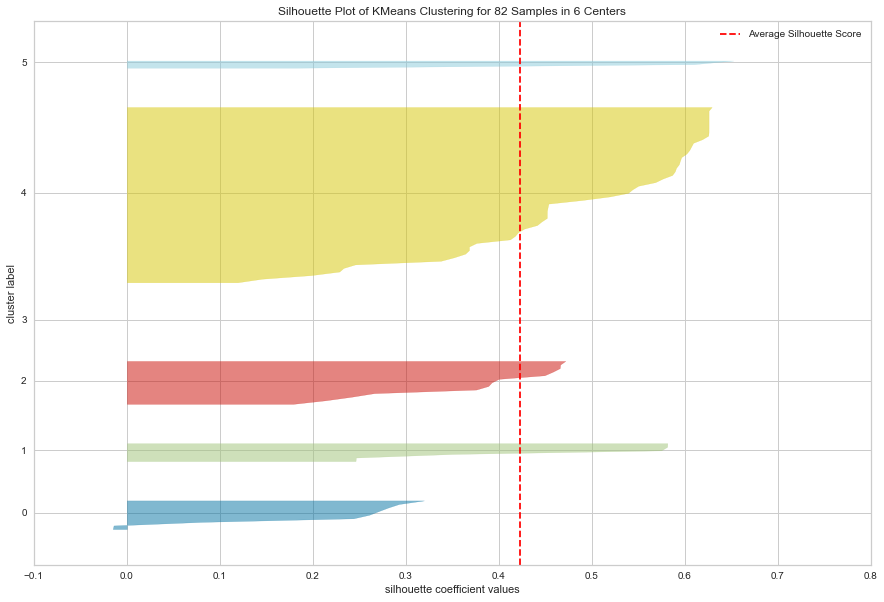

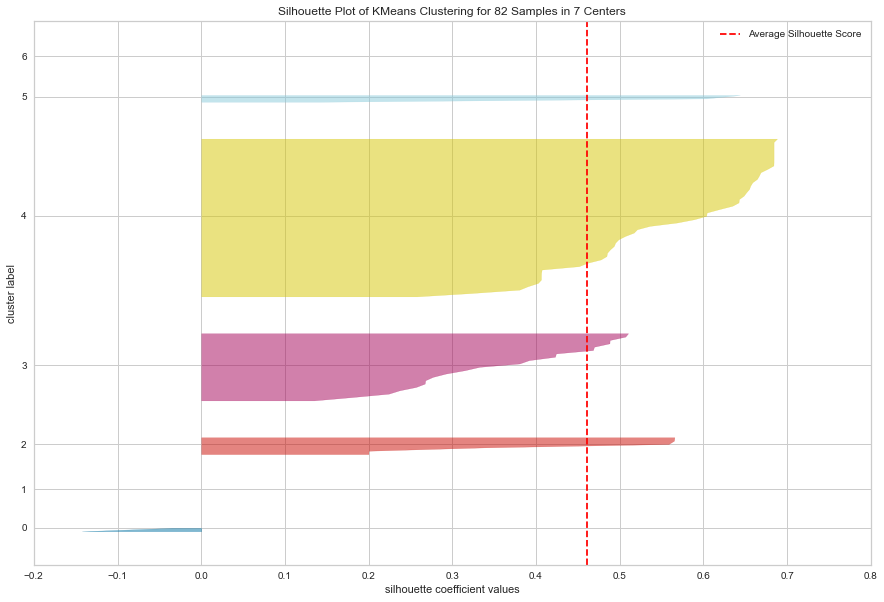

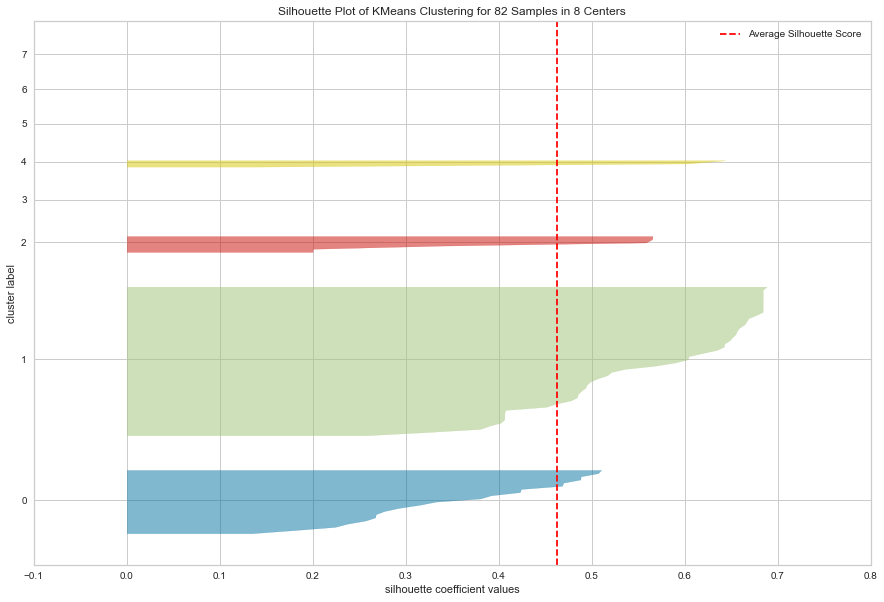

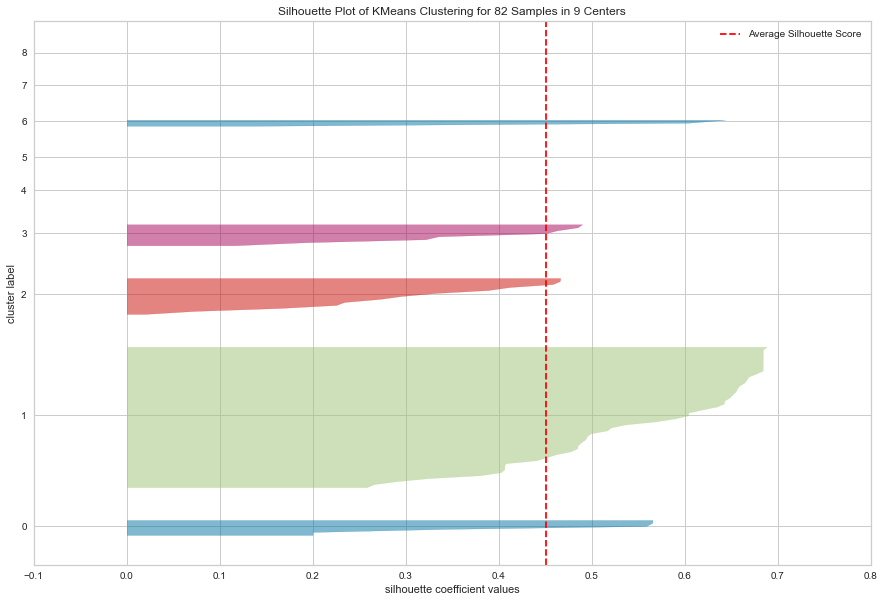

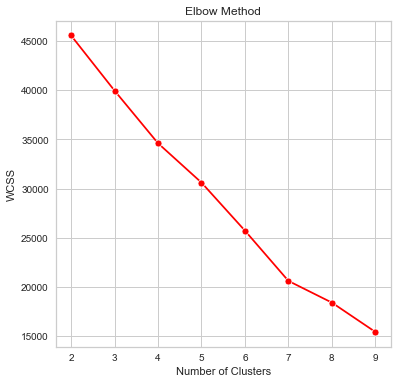

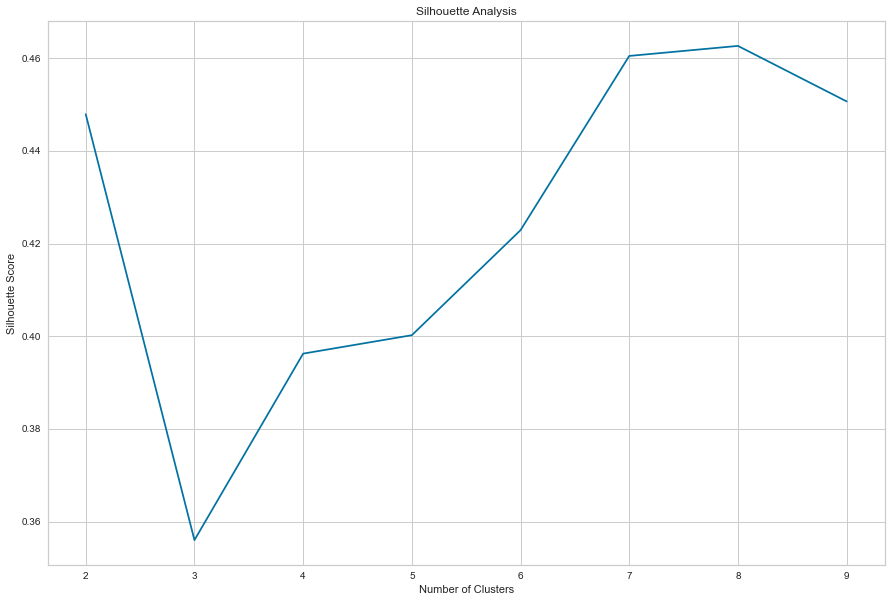

In [86]:
elbowAndSilhouette(df_h)

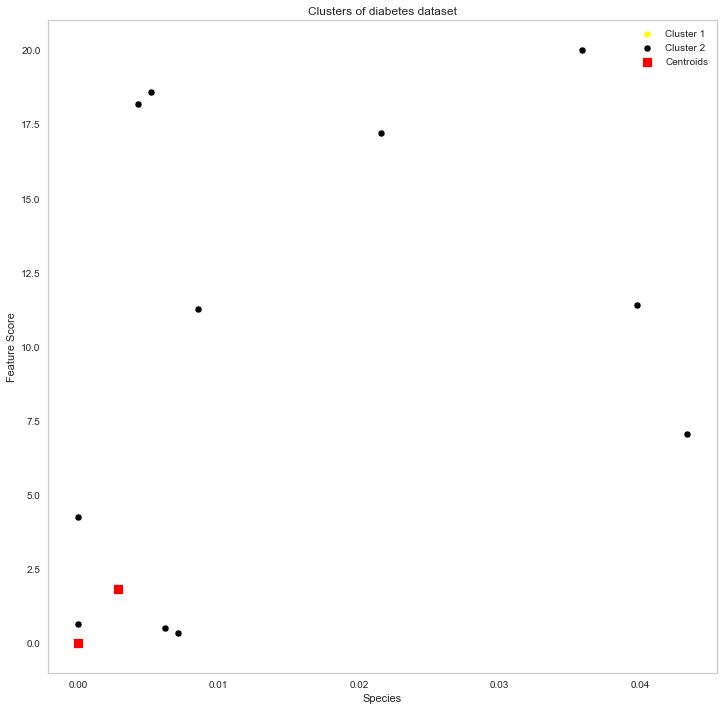

In [87]:
# applying k means = 2
X = df_h.to_numpy() # have to convert to numpy to plot graph
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X)

plt.figure(figsize=(12,12))
sns.scatterplot(X[y_kmeans == 0,0], X[y_kmeans == 0,1], color = 'yellow', label ='Cluster 1', s=50)
sns.scatterplot(X[y_kmeans == 1,0], X[y_kmeans == 1,1], color = 'black', label ='Cluster 2', s=50)
#sns.scatterplot(X[y_kmeans == 2,0], X[y_kmeans == 2,1], color = 'orange', label ='Cluster 3', s=50)
#sns.scatterplot(X[y_kmeans == 3,0], X[y_kmeans == 3,1], color = 'blue', label ='Cluster 4', s=50)
#sns.scatterplot(X[y_kmeans == 4,0], X[y_kmeans == 4,1], color = 'green', label ='Cluster 5', s=50)
#sns.scatterplot(X[y_kmeans == 5,0], X[y_kmeans == 5,1], color = 'grey', label ='Cluster 6', s=50)
sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color ='red', label='Centroids', s=100, marker=',')
plt.grid(False)
plt.title('Clusters of diabetes dataset')
plt.xlabel('Species')
plt.ylabel('Feature Score')
plt.legend()
plt.show()

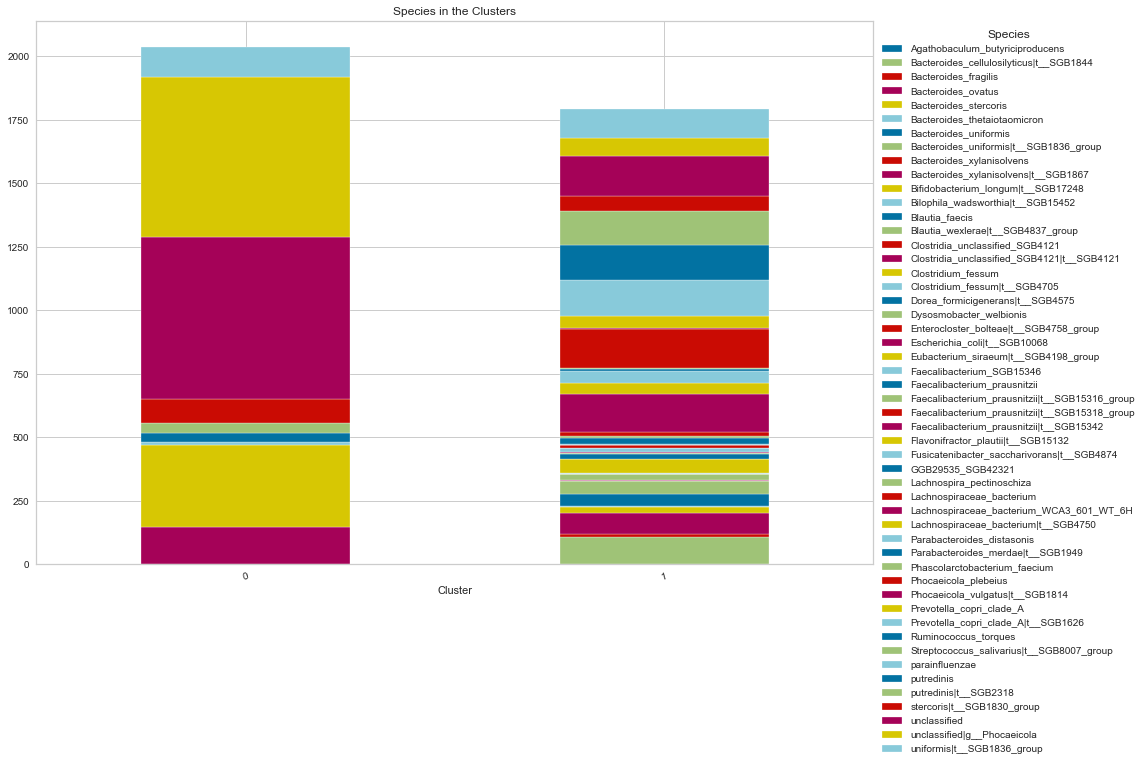

In [88]:
dict_cluster = stackedBar(df_h, y_kmeans, 2)

In [89]:
# species of clusters
print('Cluster 0 : ')
display(dict_cluster['df_0'])
print('Cluster 1 : ')
display(dict_cluster['df_1'])


Cluster 0 : 


,0,1
unclassified,639.03648,157.22640
unclassified|g__Phocaeicola,627.05821,73.13004
_Phocaeicola_vulgatus|t__SGB1814,321.06781,49.22475
_Phocaeicola_plebeius|t__SGB1903_group,147.20963,4.32085
uniformis|t__SGB1836_group,120.86617,114.82951


Cluster 1 : 


,0,1
unclassified,639.03648,157.22640
_Cutibacterium_acnes|t__SGB16955,0.00000,150.59216
Phocaeicola_vulgatus|t__SGB1814,0.00000,147.92716
parainfluenzae,12.02779,139.98585
putredinis,37.32823,137.01449


Hierarchical Clustering

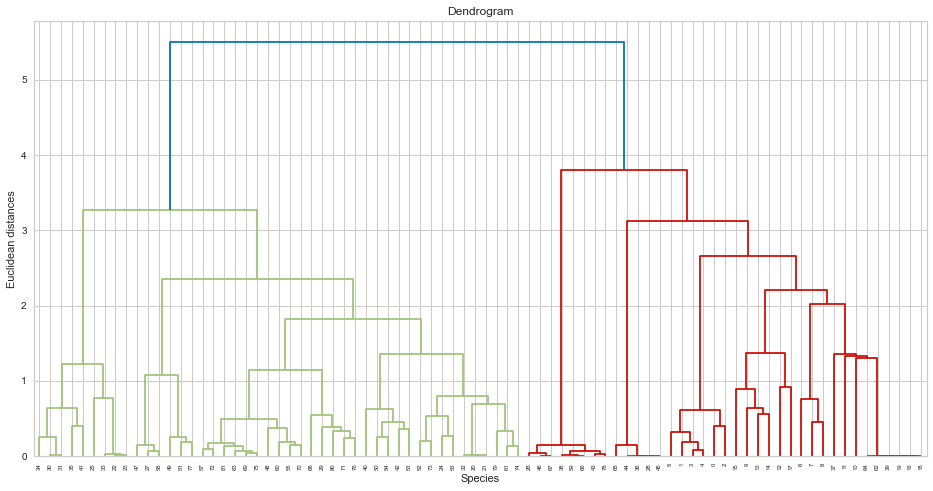

In [90]:
df_scaled_h = hierarchicalFirst(df_h)

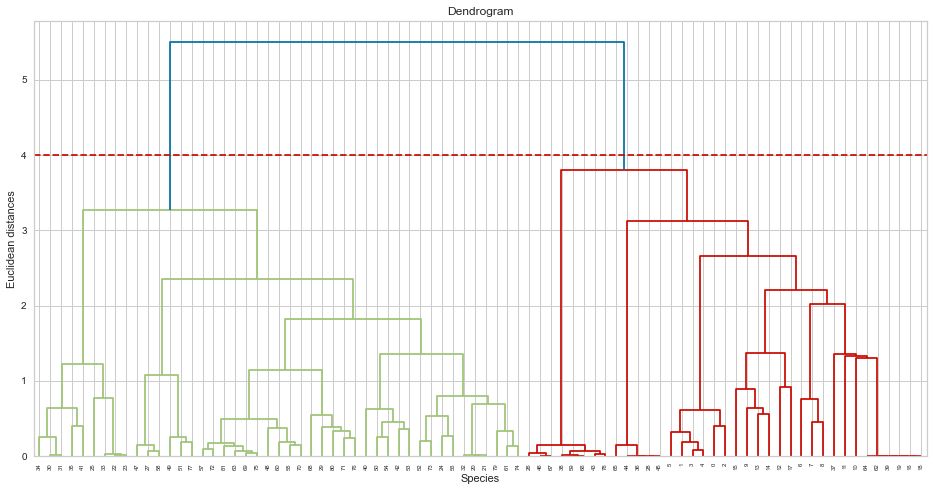

In [91]:
hierarchicalSecond(df_scaled_h,4)

In [92]:
y_hc = agglomerative(df_scaled_h, 2)
y_hc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int64)

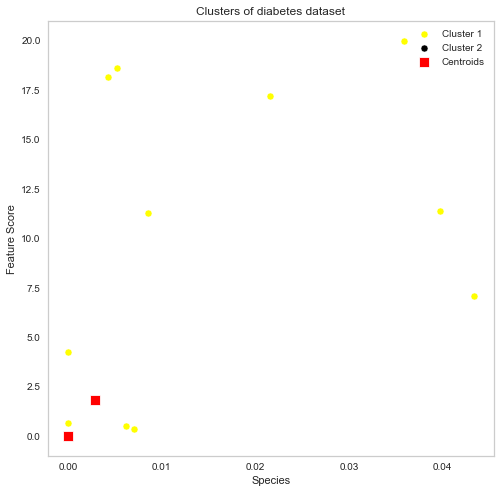

In [93]:
# agglomerative clustering = 2
X = df_h.to_numpy() # have to convert to numpy to plot graph

plt.figure(figsize=(8,8))
sns.scatterplot(X[y_hc == 0,0], X[y_hc == 0,1], color = 'yellow', label ='Cluster 1', s=50)
sns.scatterplot(X[y_hc == 1,0], X[y_hc == 1,1], color = 'black', label ='Cluster 2', s=50)
#sns.scatterplot(X[y_hc == 2,0], X[y_hc == 2,1], color = 'orange', label ='Cluster 3', s=50)
#sns.scatterplot(X[y_hc == 3,0], X[y_hc == 3,1], color = 'blue', label ='Cluster 4', s=50)
#sns.scatterplot(X[y_kmeans == 4,0], X[y_kmeans == 4,1], color = 'green', label ='Cluster 5', s=50)
#sns.scatterplot(X[y_kmeans == 5,0], X[y_kmeans == 5,1], color = 'grey', label ='Cluster 6', s=50)
sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color ='red', label='Centroids', s=100, marker=',')
plt.grid(False)
plt.title('Clusters of diabetes dataset')
plt.xlabel('Species')
plt.ylabel('Feature Score')
plt.legend()
plt.show()

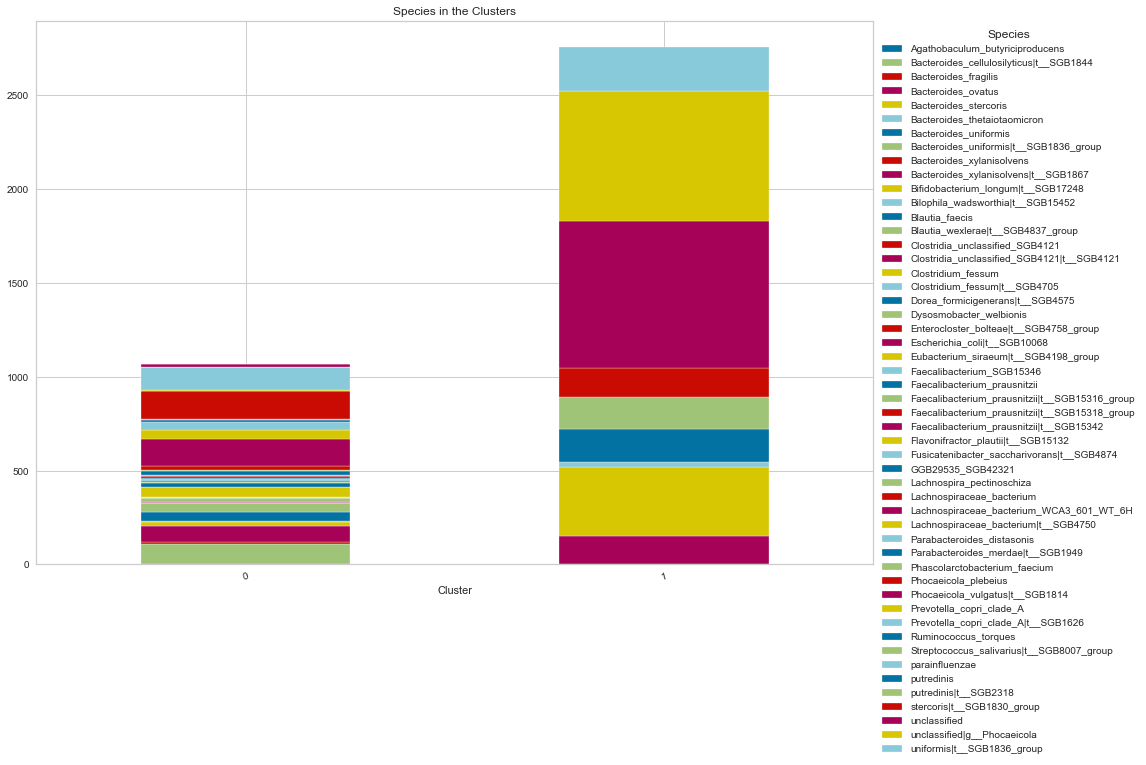

In [94]:
dict_cluster = stackedBar(df_h, y_hc, 2)

In [96]:
# species of cluster 1
print('Cluster 0 : ')
display(dict_cluster['df_0'])
print('Cluster 1 : ')
display(dict_cluster['df_1'])

Cluster 0 : 


,0,1
_Cutibacterium_acnes|t__SGB16955,150.49463,0.09753
Phocaeicola_vulgatus|t__SGB1814,147.92716,0.00000
parainfluenzae,124.22639,27.78725
Bacteroides_cellulosilyticus|t__SGB1844,109.46846,0.00000
Bacteroides_ovatus,81.98701,0.00000


Cluster 1 : 


,0,1
unclassified,12.62243,783.64045
unclassified|g__Phocaeicola,4.17331,696.01494
_Phocaeicola_vulgatus|t__SGB1814,4.12015,366.17241
uniformis|t__SGB1836_group,0.48912,235.20656
putredinis,0.05258,174.29014
